<div style="border: 1px solid black; padding: 10px;">
<table>
<tr>
    <td width=20%>
        <br/> <a style="font-size: 16px; font-weight: italic"> Data Scientist Junior </a> <br/> <br/> Théo JEAN <br/>
    </td>
    <td width=60%>
        <center>
            <h1>Bank attrition analysis</h1>
            <h2> <font color='red'> What type of customer is likely to change bank?</font> </h2>
        </center>
    </td>
    <td width=20%>
        <a style="font-size: 16px; font-weight: bold"> Personal project 1 </a>
         <br/> 07/04/2024 <br/>
    </td>
</tr>
</table>
</div>

https://www.kaggle.com/datasets/manjuahuja/bank-churner

# Objective : 

Maximise f1_score, we want to recognise as much as possible all the attrited customers

Développer une app streamlit permettant de fournir des caractéristiques de clients et qui offre des analyses statistiques dessus + la prédiction d'attrition. 

En termes de contenu :
- Statistiques descriptives
- Modélisation et optimisation avec GridSearch + Optuna
- OOP pour l'EDA et pipeline
- Comparaison avec du DL
- Une map folium
- Affichage des résultats en dynamique comme sur Optuna pour l'entrainement

A faire : 
- Quid de la corrélation ?
- Amélio modèle

# First overview of the dataset :

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc, accuracy_score, make_scorer, precision_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

In [13]:
df = pd.read_csv("BankChurners.csv", sep=",")

In [14]:
df.head()

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  \
0              39  ...       12691.0                  777          11914.0   
1              44  ...        8256.0                  864           7392.0   
2              36  ...        3418.0                    0           3418.0   
3              34  ...        3313.0                 2517            796.0   
4              21  ...        4716.0                    0           4716.0   

   Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
0                 1.335             1144              42                1.625   
1                 1.541             1291              33                3.714   
2                 2.594             1887              20                2.333   
3                 1.405             1171              20                2.333   
4                 2.175              816              28                2.500   

   Avg_Utilization_Ratio  \
0                  0.061   
1                  0.105   
2                  0.000   
3                  0.760   
4                  0.000   

   Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1  \
0                                           0.000093                                                                                    
1                                           0.000057                                                                                    
2                                           0.000021                                                                                    
3                                           0.000134                                                                                    
4                                           0.000022                                                                                    

   Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2  
0                                            0.99991                                                                                   
1                                            0.99994                                                                                   
2                                            0.99998                                                                                   
3                                            0.99987                                                                                   
4                                            0.99998                                                                                   

[5 rows x 23 columns]

In [15]:
# deletion of last two columns not required for analysis and the first
df = df.iloc[:, :-2] 

In [16]:
class DataSummary:
    """
    Classe de base pour résumer les données.
    """
    def __init__(self, df: pd.DataFrame):
        self.df = df

    def summary(self):
        raise NotImplementedError("La méthode summary doit être implémentée par les sous-classes.")

    def format_summary(self, summary_df):
        lines = []
        headers = summary_df.columns
        column_widths = [max(len(str(row[col])) for row in summary_df.to_dict('records')) for col in headers]
        column_widths = [max(width, len(header)) for width, header in zip(column_widths, headers)]
        header_line = "| " + " | ".join(f"{col:<{width}}" for col, width in zip(headers, column_widths)) + " |"
        lines.append(header_line)
        lines.append('-' * len(header_line))
        for _, row in summary_df.iterrows():
            line = "| " + " | ".join(f"{str(row[col]):<{width}}" for col, width in zip(headers, column_widths)) + " |"
            lines.append(line)
        return "\n".join(lines)


class QuantitativeSummary(DataSummary):
    """
    Classe pour résumer les données quantitatives.
    """
    def summary(self):
        quanti_col = self.df.select_dtypes(include=['number'])
        summary = []

        for col in quanti_col.columns:
            unique_values = quanti_col[col].dropna().unique()
            missing_percentage = round(self.df[col].isna().mean() * 100, 2)
            min_value = quanti_col[col].min()
            max_value = quanti_col[col].max()
            mean_value = round(quanti_col[col].mean(), 2)
            std_value = round(np.std(quanti_col[col]), 2)
            median_value = round(quanti_col[col].median(), 2)
            summary.append({
                'Variable': col,
                'Type': quanti_col[col].dtype,
                'Missing %': f"{missing_percentage:.2f}%",
                'Mean': mean_value,
                'Median': median_value,
                'Std': std_value,
                'Min': min_value,
                'Max': max_value,
                'Unique Values (Top 5)': unique_values[:5]
            })

        return pd.DataFrame(summary)


class QualitativeSummary(DataSummary):
    """
    Classe pour résumer les données qualitatives.
    """
    def summary(self):
        quali_col = self.df.select_dtypes(exclude=['number'])
        summary = []

        for col in quali_col.columns:
            missing_percentage = round(self.df[col].isna().mean() * 100, 2)
            most_freq_value = quali_col[col].mode().iloc[0] if not quali_col[col].mode().empty else 'N/A'
            freq_distrib = quali_col[col].value_counts(normalize=True).to_dict()
            top_5_cat = ', '.join([f"{k} ({v:.2%})" for k, v in list(freq_distrib.items())[:5]])
            summary.append({
                'Variable': col,
                'Type': quali_col[col].dtype,
                'Missing %': f"{missing_percentage:.2f}%",
                'Most Frequent Value': most_freq_value,
                'Unique Values (Top 5)': top_5_cat
            })

        return pd.DataFrame(summary)


class Info:
    """
    Classe permettant un aperçu macro des données en affichant quelques statistiques descriptives
    des données numériques et catégorielles.
    """
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.quant_summary = QuantitativeSummary(df)
        self.qual_summary = QualitativeSummary(df)
        print("\nObjet Info créé")

    def display_summary(self):
        quanti_summary_df = self.quant_summary.summary()
        quali_summary_df = self.qual_summary.summary()

        print()
        print("Dataset of", len(self.df), "rows and", len(self.df.columns), "variables.")
        print()
        print("***" * 40)
        print()
        print("Quantitative Variables Summary:", len(quanti_summary_df))
        print(self.quant_summary.format_summary(quanti_summary_df))
        print()
        print("***" * 40)
        print()
        print("Qualitative Variables Summary:", len(quali_summary_df))
        print(self.qual_summary.format_summary(quali_summary_df))


In [17]:
info = Info(df)


Objet Info créé


In [18]:
info.display_summary()


Dataset of 10127 rows and 21 variables.

************************************************************************************************************************

Quantitative Variables Summary: 15
| Variable                 | Type    | Missing % | Mean         | Median      | Std         | Min         | Max         | Unique Values (Top 5)                               |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| CLIENTNUM                | int64   | 0.00%     | 739177606.33 | 717926358.0 | 36901961.36 | 708082083.0 | 828343083.0 | [768805383 818770008 713982108 769911858 709106358] |
| Customer_Age             | int64   | 0.00%     | 46.33        | 46.0        | 8.02        | 26.0        | 73.0        | [45 49 51 40 44]                                    |
| Dependent_count          | int64   | 0.00%     | 2.35         | 2.0         | 1.3         | 0.0

### **DESCRIPTION DES VARIABLES :**

**CLIENTNUM** : Quantitative, identifiant du client 

**Attribution_Flag** : Qualitative, toujours client ou pas

**Customer_Age** : Quantitative, age du client

**Gender** : Qualitative, sexe du client

**Dependent_count** : Quantitative, nombre de compte du client

**Education_level** : Qualitative, niveau d'éducation du client

**Marital_Status** : Qualitative, situation amoureuse du client

**Income_category** : Qualitative, tranche de revenue du client

**Card_Category** : Qualitative, type de carte de crédit du client

**Months_on_book** : Quantitative, période en mois où le client est avec cette banque

**Total_Relationship_Count** : Quantitative, nombre total de produits détenus par le client

**Months_Inactive_12_mon** : Quantitative, Nombre de mois inactifs au cours des 12 derniers mois

**Contacts_Count_12_mon** : Quantitative, Nombre de contacts avec la banque au cours des 12 derniers mois

**Credit_Limit** : Quantitative, plafond bancaire du client

**Total_Revolving_Bal** : Quantitative, Total du crédit renouvelable actuel

**Avg_Open_To_Buy**: Quantitative, Moyenne sur les 12 derniers mois du montant qu'il restait à dépenser en fin de mois

**Total_Amt_Chng_Q4_Q1** : Quantitative, Variation du montant des transactions (T4 par rapport au T1)

**Total_Trans_Amt** : Quantitative, Montant total des transactions (12 derniers mois)

**Total_Trans_Ct** : Quantitative, Nombre total de transactions (12 derniers mois)

**Total_Ct_Chng_Q4_Q1** : Quantitative, Variation du nombre d’opérations (T4 par rapport au T1)

**Avg_Utilization_Ratio** : Quantitative, Taux moyen d'utilisation des cartes

Target value : **Attrition_Flag**

**RESUME STATISTIQUES DESCRIPTIVES / PROFIL DES CLIENTS DE LA BANQUE :**

Profil démographique : 
- La majorité des clients ont un âge compris entre 41 et 52 ans, avec une médiane de 46 ans.
- La plupart des clients ont entre 1 et 3 personnes à charge, avec une médiane de 2.3.
- En moyenne, les clients sont clients depuis 36 mois, avec la plupart des clients ayant entre 31 et 40 mois d'ancienneté.

Engagement et relation avec la banque :

- Les clients détiennent en moyenne 3.8 produits bancaires.
- En moyenne, les clients ont été inactifs pendant 2.3 mois au cours des 12 derniers mois.
- Les clients ont eu en moyenne 2.5 contacts avec la banque au cours des 12 derniers mois.

Santé financière :

- La limite de crédit à la consommation en moyenne des clients se situe autour de 8600, avec une variation significative.
- La plupart des clients ont un solde renouvelable entre 360 et 1800.
- En moyenne, les clients ont un montant ouvert à l'achat entre 1300 et 9900.

Comportement financier :

- Le changement total du montant au cours du quatrième trimestre par rapport au premier trimestre est en moyenne de 0.76.
- La plupart des clients ont un montant total de transaction entre 2200 et 4700.
- En moyenne, les clients ont entre 45 et 81 transactions.

In [19]:
# Conversion de certaines colonnes en catégories
convert_col = ['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category' ]

for col in convert_col:
    df[col] = df[col].astype('category')

In [20]:
# any duplicated obs verification 
df.duplicated().any() 

False

In [133]:
# Let's check for missing hidden values in categorical variables

for col in df.select_dtypes(include='category').columns:
    print(f'{col.ljust(30, "-")} : {df[col].unique()}')

Attrition_Flag---------------- : ['Existing Customer', 'Attrited Customer']
Categories (2, object): ['Attrited Customer', 'Existing Customer']
Gender------------------------ : ['M', 'F']
Categories (2, object): ['F', 'M']
Education_Level--------------- : ['High School', 'Graduate', 'Uneducated', 'Unknown', 'College', 'Post-Graduate', 'Doctorate']
Categories (7, object): ['College', 'Doctorate', 'Graduate', 'High School', 'Post-Graduate', 'Uneducated', 'Unknown']
Marital_Status---------------- : ['Married', 'Single', 'Unknown', 'Divorced']
Categories (4, object): ['Divorced', 'Married', 'Single', 'Unknown']
Income_Category--------------- : ['$60K - $80K', 'Less than $40K', '$80K - $120K', '$40K - $60K', '$120K +', 'Unknown']
Categories (6, object): ['$120K +', '$40K - $60K', '$60K - $80K', '$80K - $120K', 'Less than $40K', 'Unknown']
Card_Category----------------- : ['Blue', 'Gold', 'Silver', 'Platinum']
Categories (4, object): ['Blue', 'Gold', 'Platinum', 'Silver']


We can see that in `Education_Level`, `Marital_Status` and `Income_Category` there are Unknown values

In [134]:
unknown_col = ['Education_Level', 'Marital_Status', 'Income_Category']

for col in unknown_col:
    print(f"{col} : {len(df[df[col] == 'Unknown'])}")
    print(round((df[col] == 'Unknown').mean() * 100, 2),'%')
    print('-----')

Education_Level : 1519
15.0 %
-----
Marital_Status : 749
7.4 %
-----
Income_Category : 1112
10.98 %
-----


On va utiliser des modèles qui puissent gérer les valeurs manquantes. On verra aussi dans les erreurs de mauvaise classement si les valeurs inconues ont joué un rôle dans la mauvaise prédiction.

# 1. Exploratory Data Analysis (EDA)

## 1.1. Variables qualitatives:

In [137]:
string_columns = df.select_dtypes(include=['category'])

for i in string_columns.columns:
    print(f"Décompte des valeurs pour la colonne '{i}':")
    print(string_columns[i].value_counts().to_string(), end="\n\n")

Décompte des valeurs pour la colonne 'Attrition_Flag':
Attrition_Flag
Existing Customer    8500
Attrited Customer    1627

Décompte des valeurs pour la colonne 'Gender':
Gender
F    5358
M    4769

Décompte des valeurs pour la colonne 'Education_Level':
Education_Level
Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451

Décompte des valeurs pour la colonne 'Marital_Status':
Marital_Status
Married     4687
Single      3943
Unknown      749
Divorced     748

Décompte des valeurs pour la colonne 'Income_Category':
Income_Category
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727

Décompte des valeurs pour la colonne 'Card_Category':
Card_Category
Blue        9436
Silver       555
Gold         116
Platinum      20



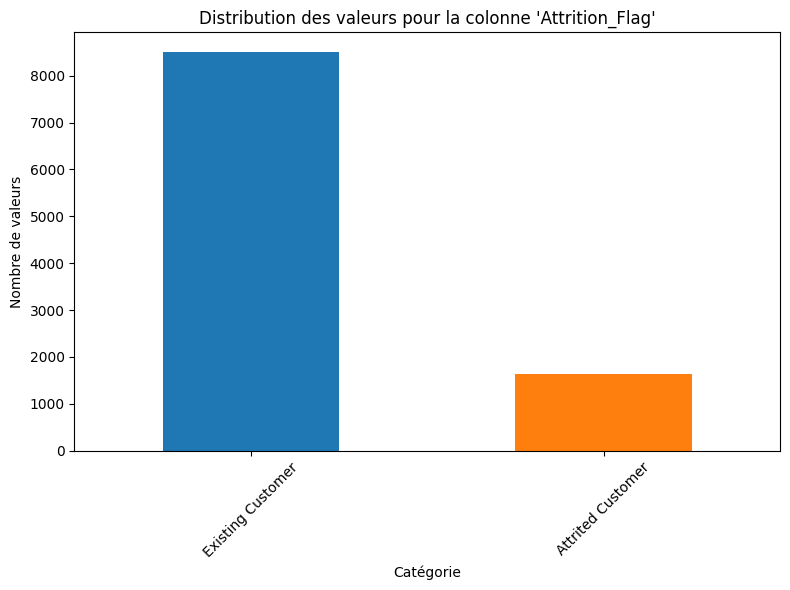

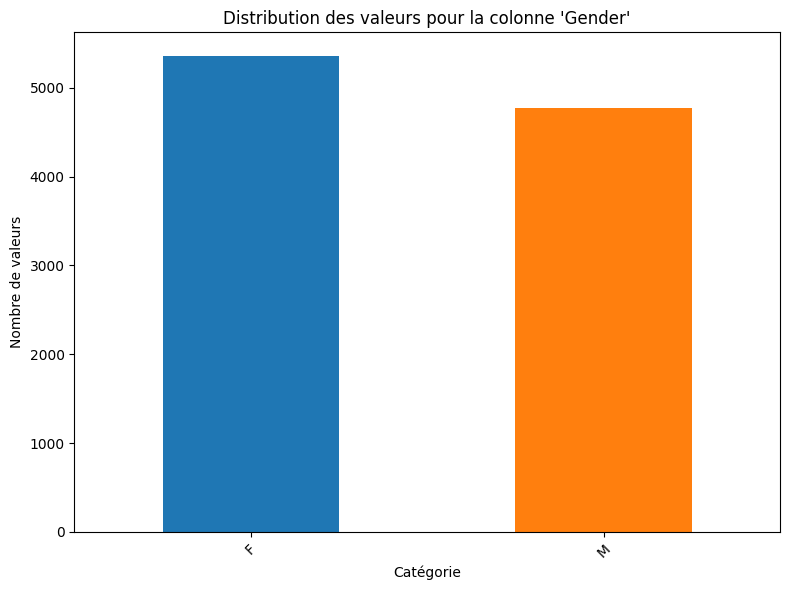

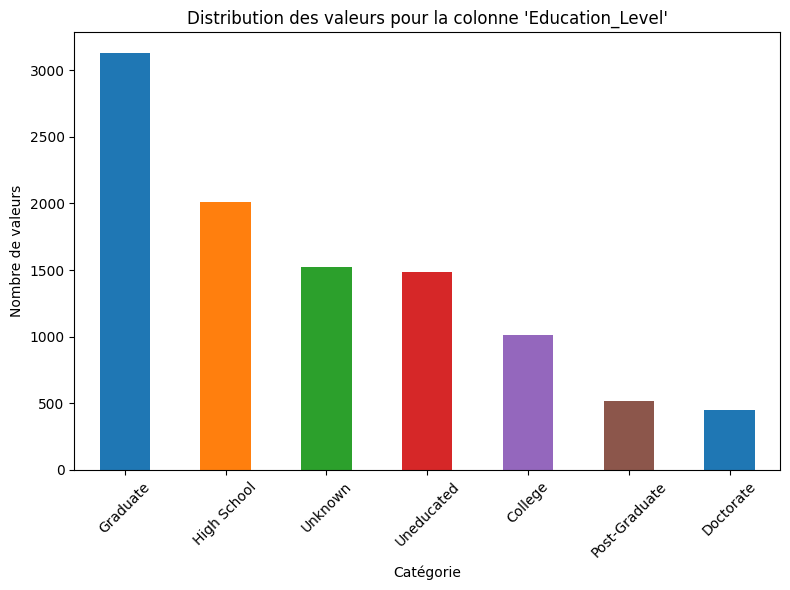

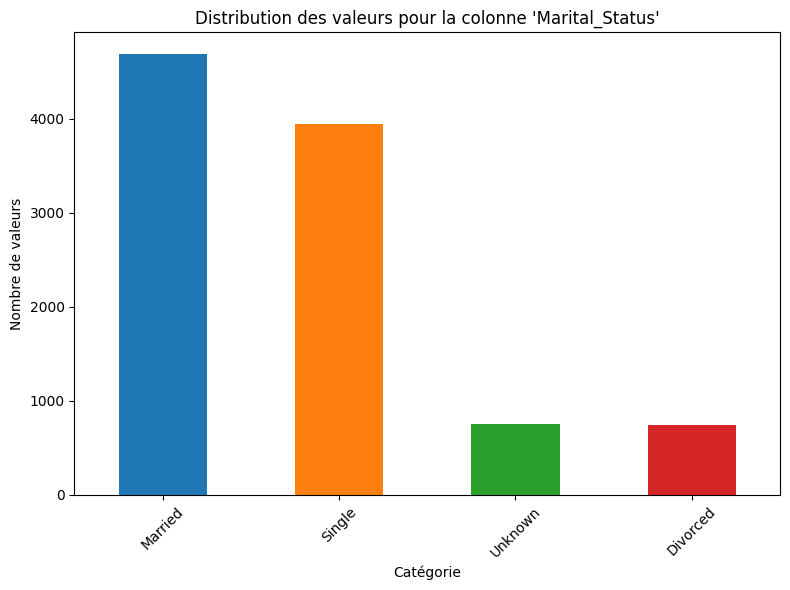

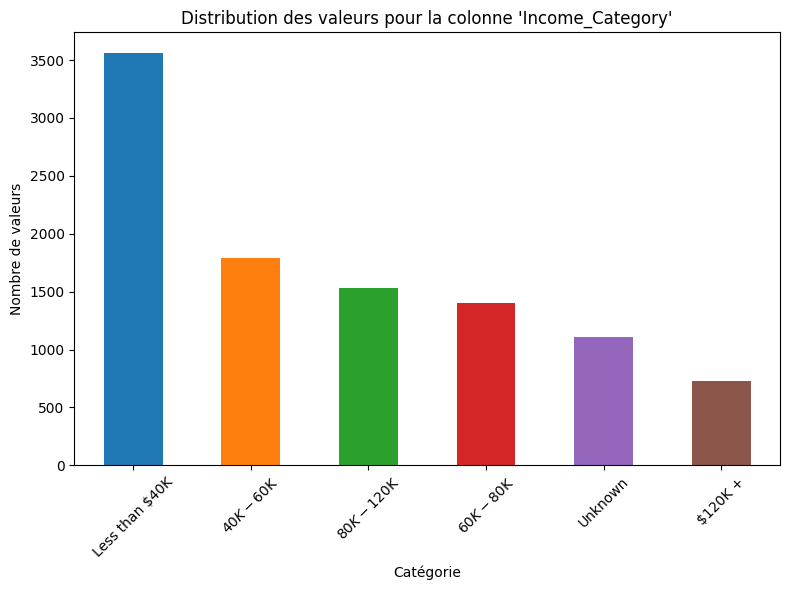

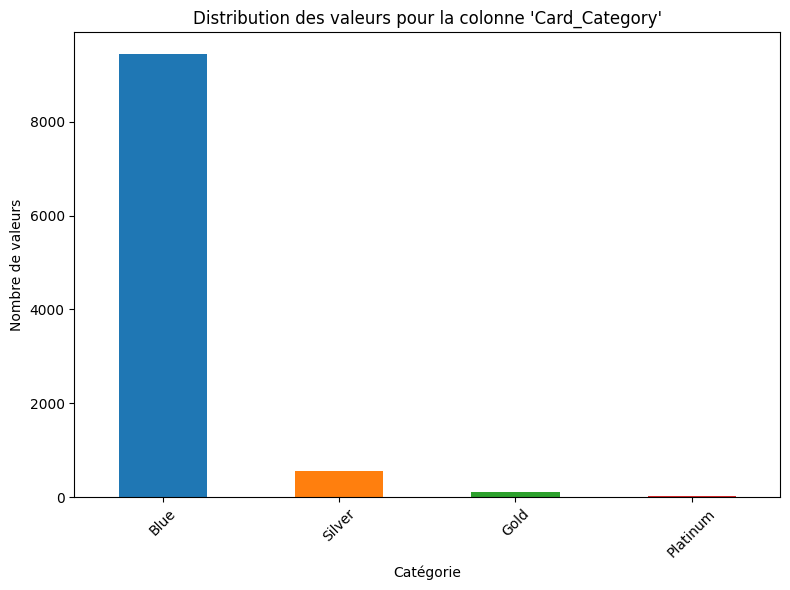

In [18]:
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Itération sur les colonnes de type string et affichage des graphiques
for col in string_columns.columns:
    plt.figure(figsize=(8, 6))
    df[col].value_counts().plot(kind='bar', color=custom_colors)
    plt.title(f"Distribution des valeurs pour la colonne '{col}'")
    plt.xlabel('Catégorie')
    plt.ylabel('Nombre de valeurs')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 1.2. Variables quantitatives :

In [19]:
numeric_columns = df.select_dtypes(include=['int64', 'float64'])

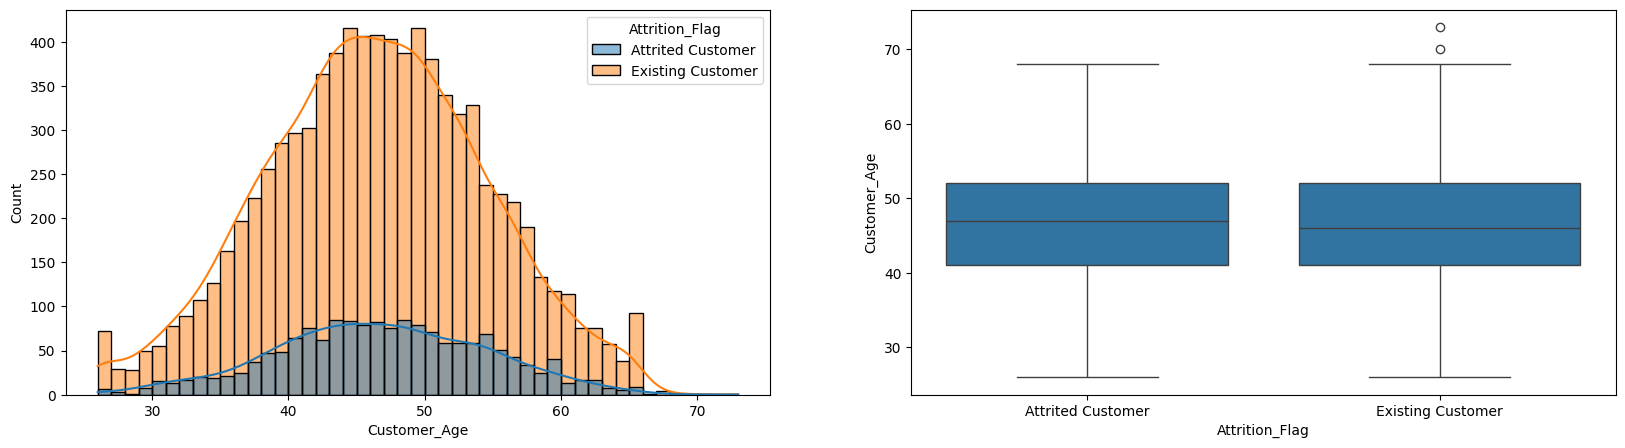

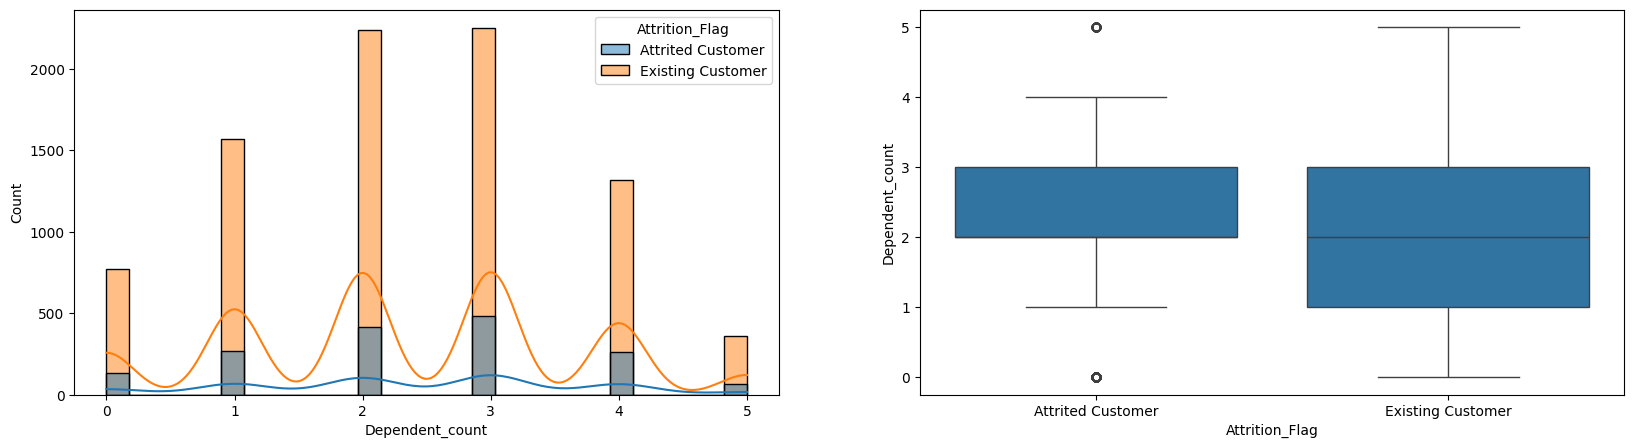

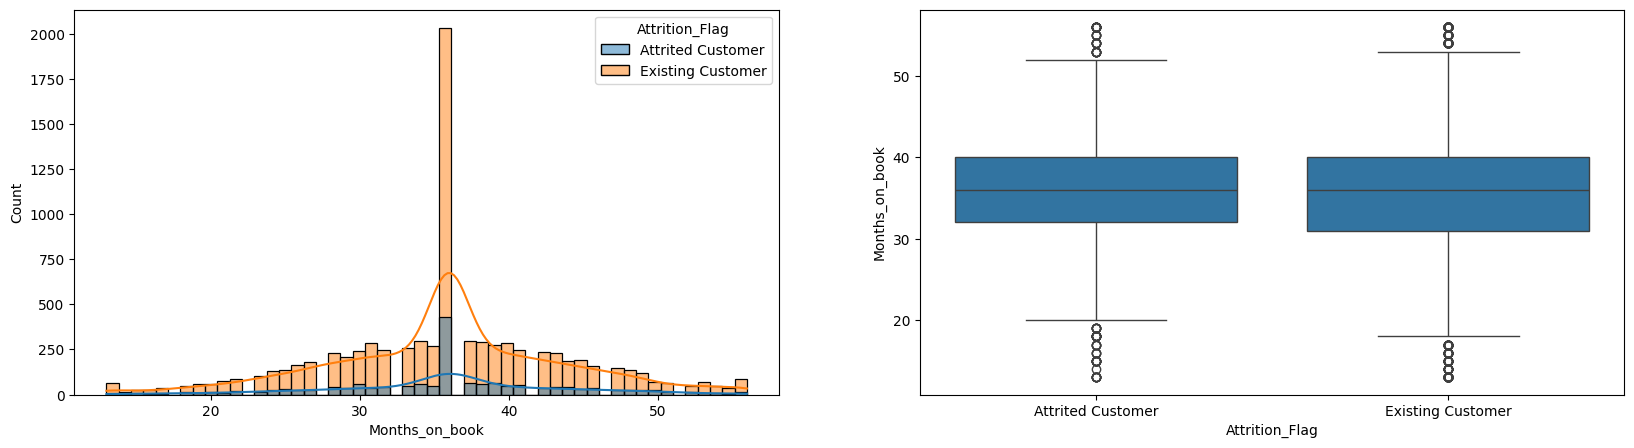

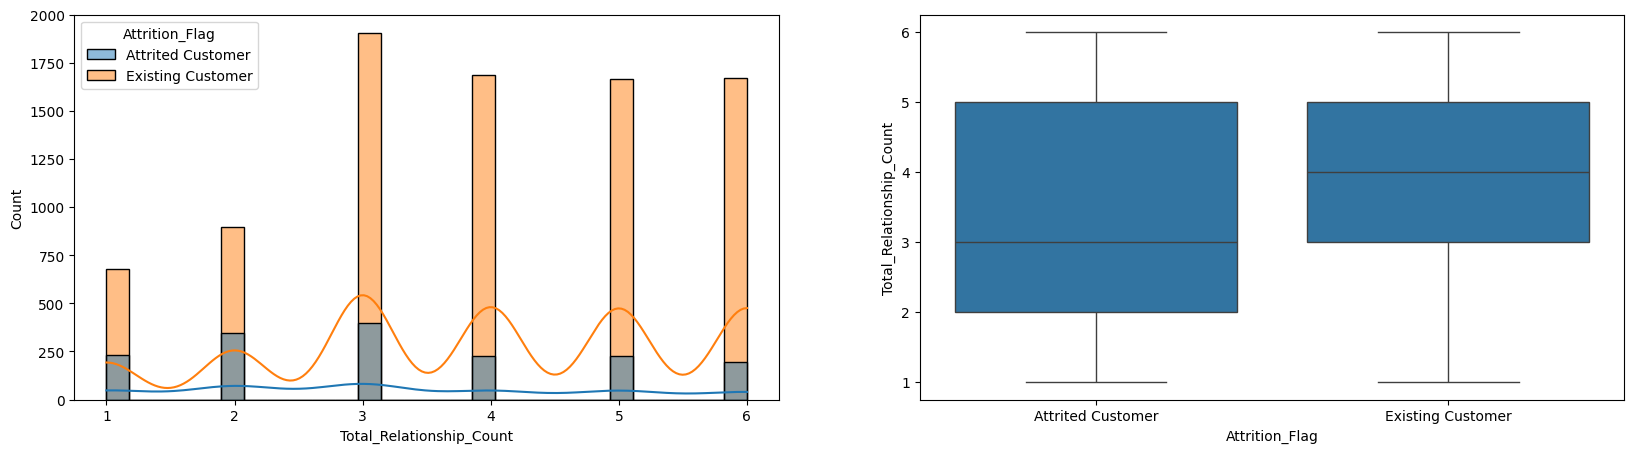

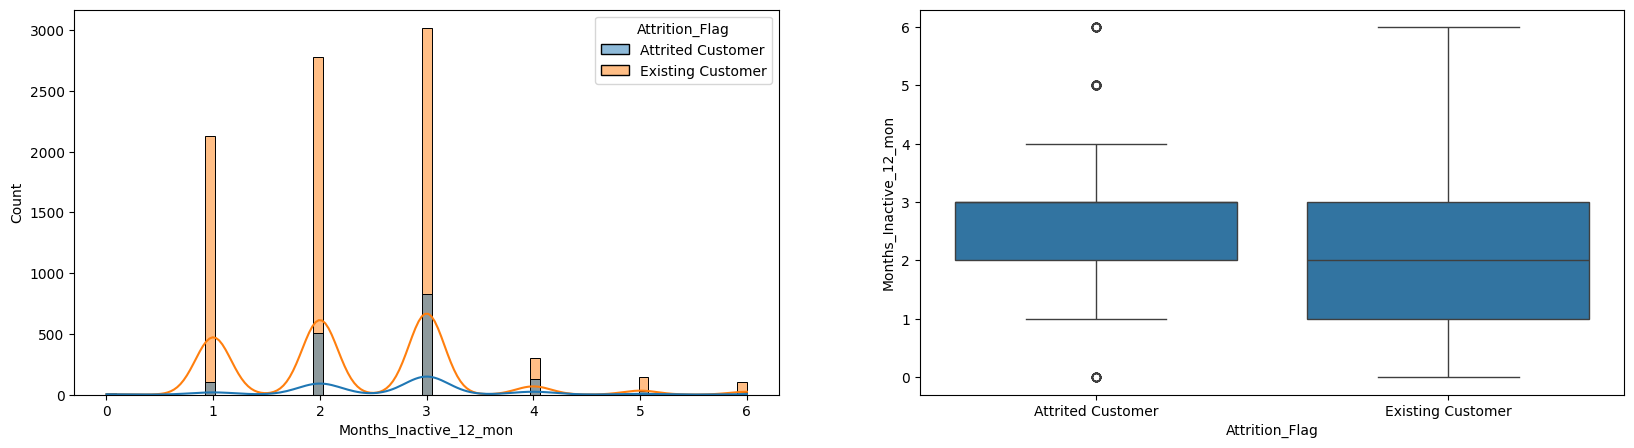

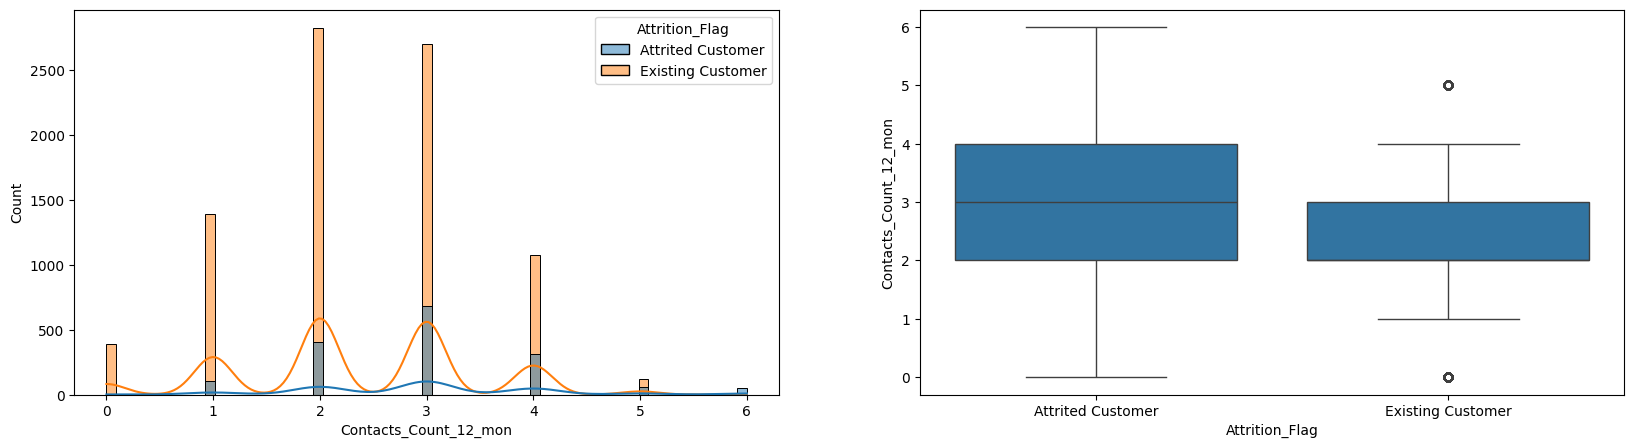

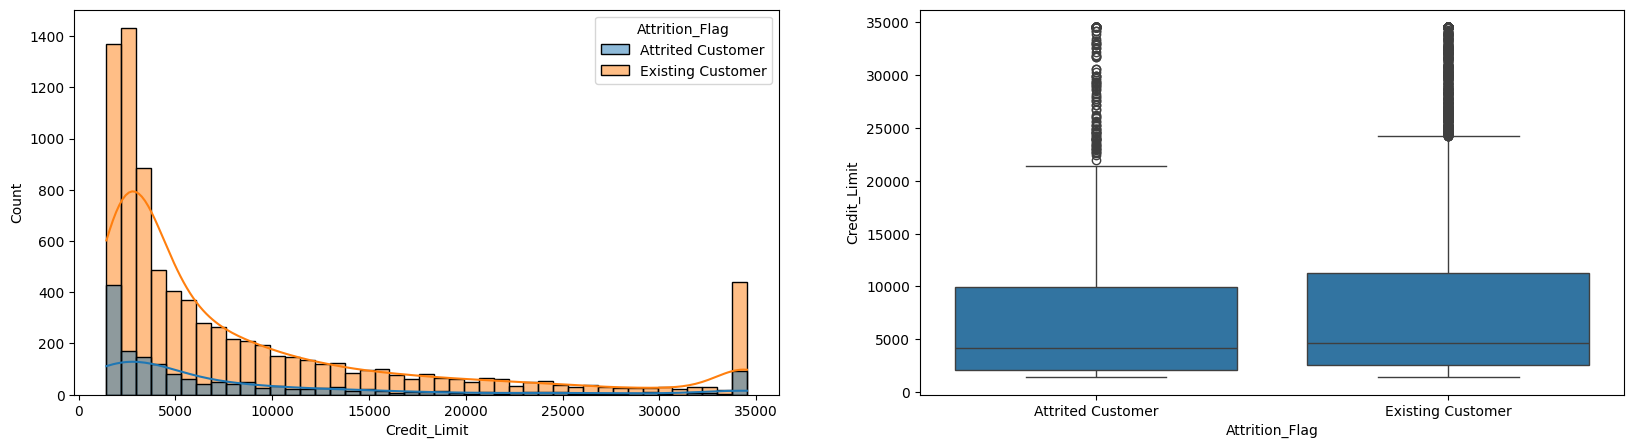

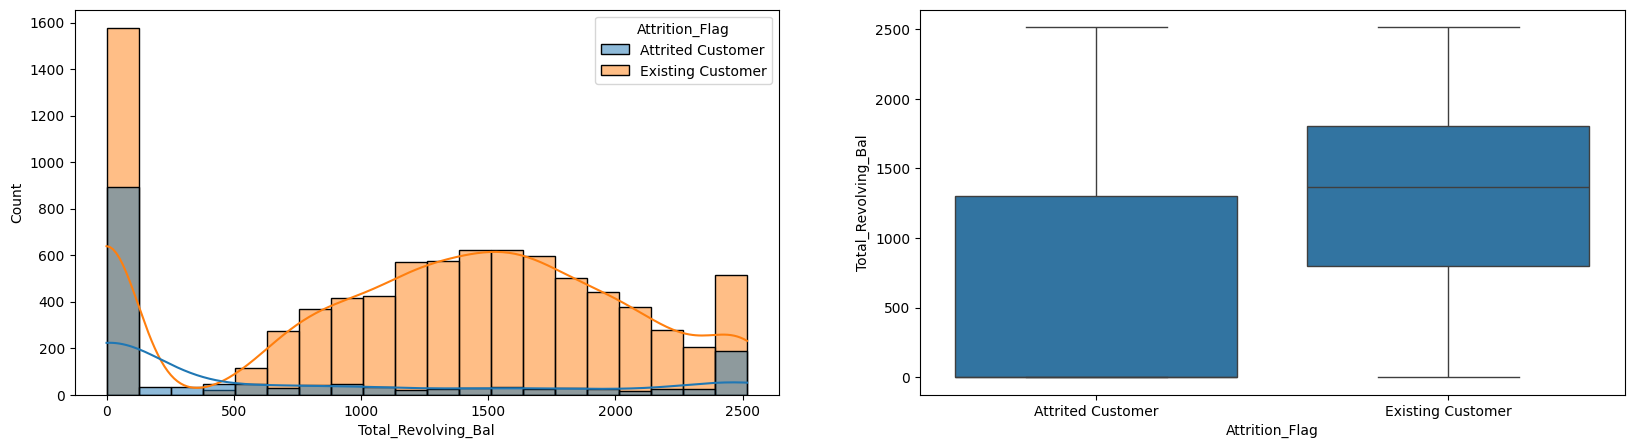

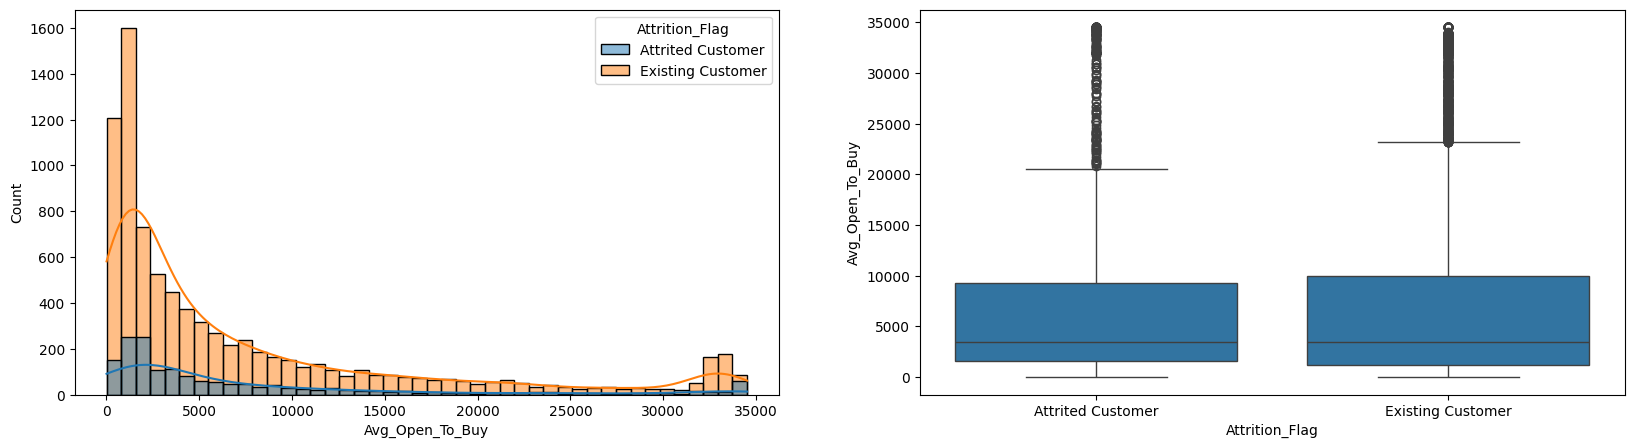

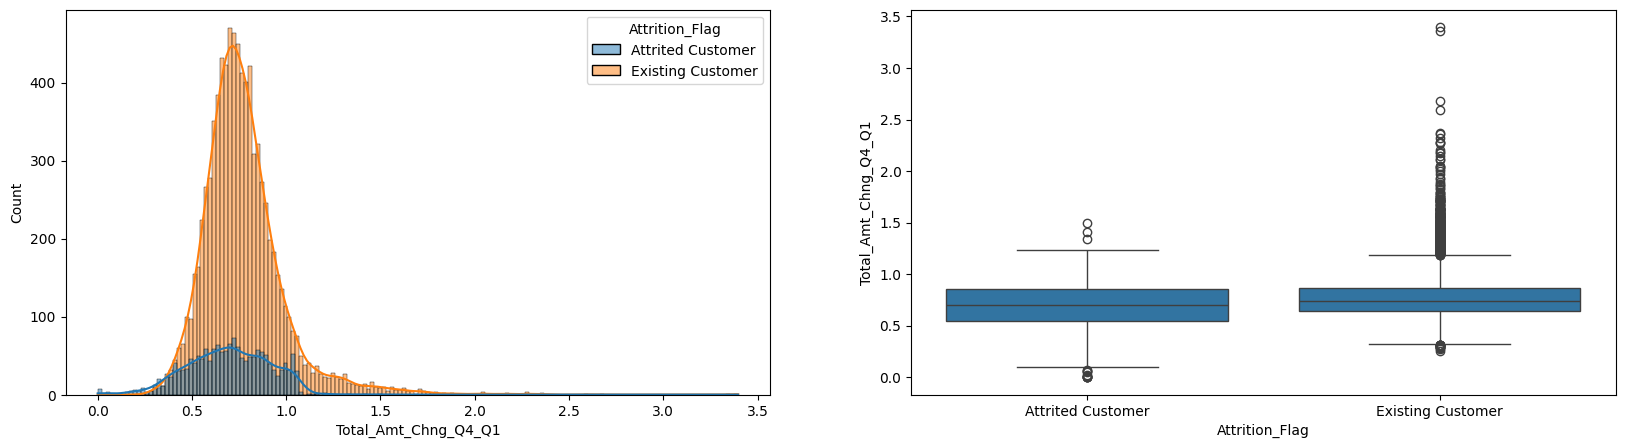

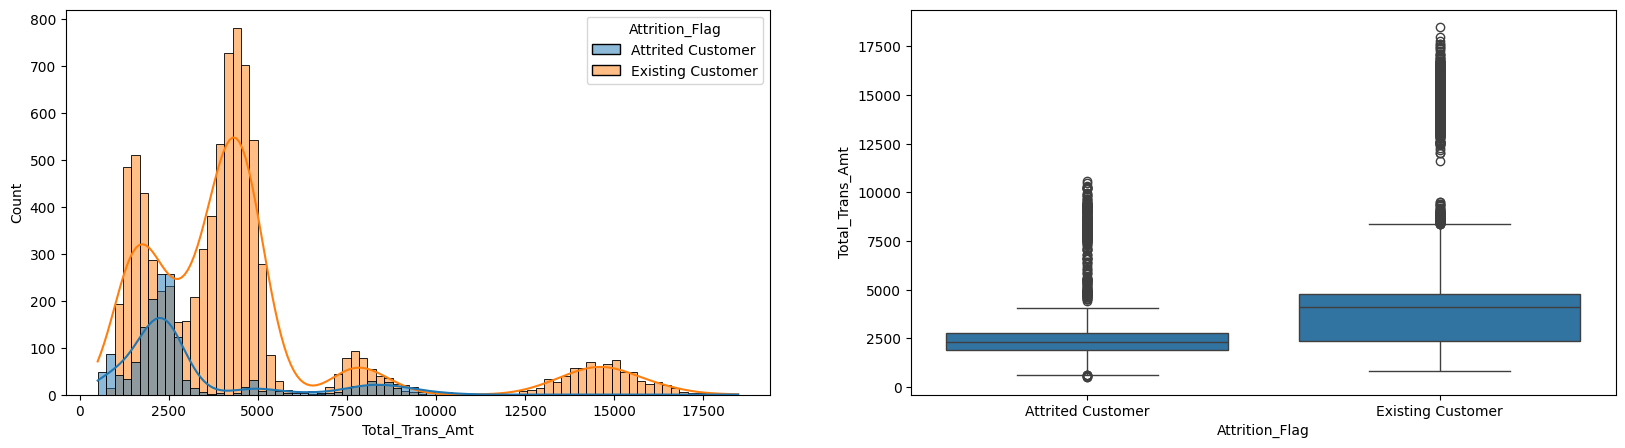

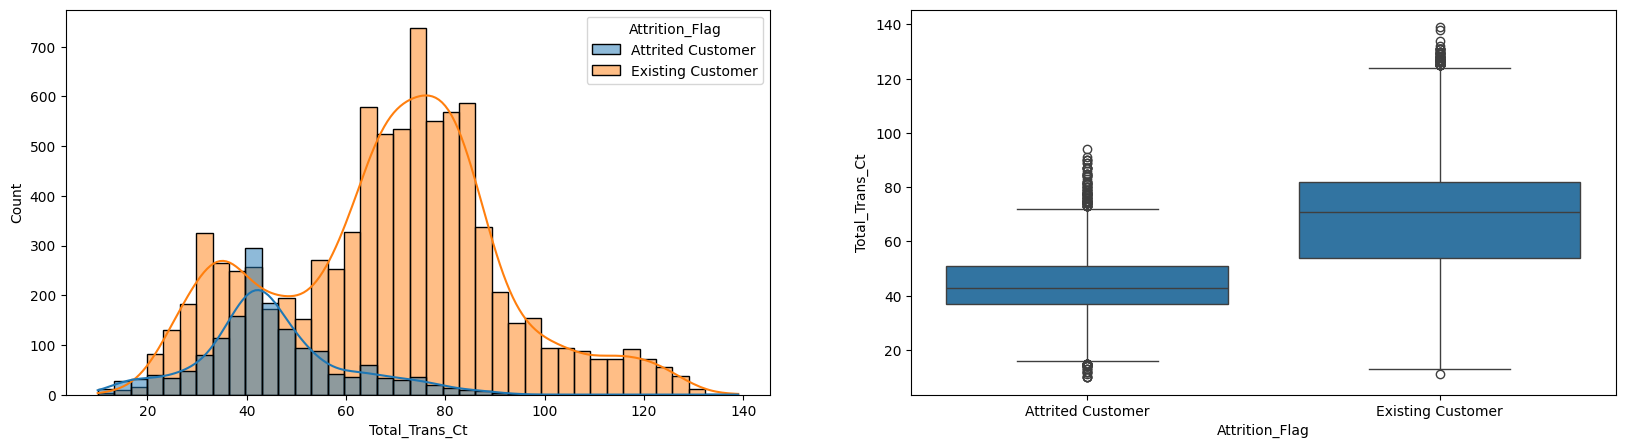

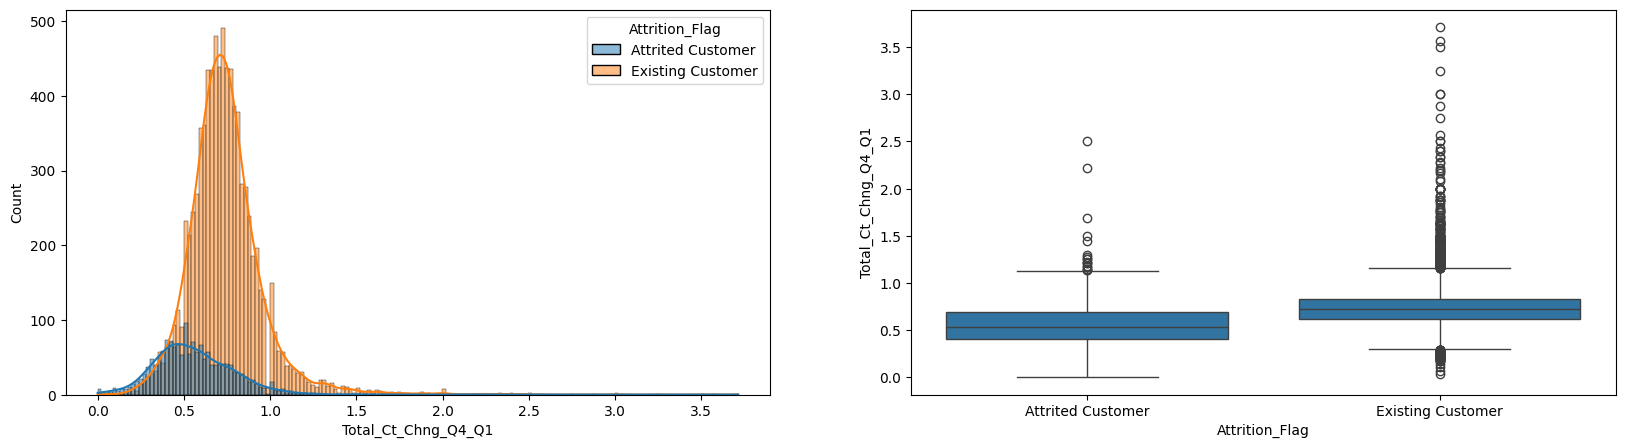

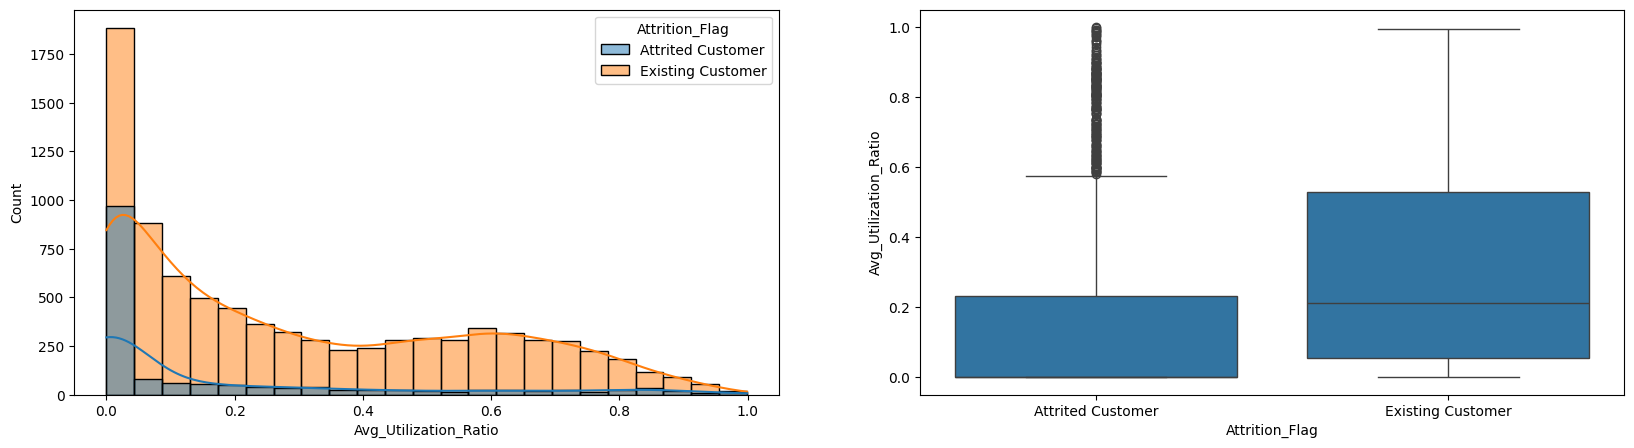

In [20]:
def plot_box(var):
    plt.subplot(1, 2, 1)  # Met le graphique à gauche de l'écran
    sns.histplot(data=df, x=var, hue='Attrition_Flag', kde=True)  # kde=True permet de mettre la densité
    
    plt.subplot(1, 2, 2)  # Met le graphique à droite de l'écran
    sns.boxplot(x='Attrition_Flag', y=var, data=df)
    
    plt.show()

for col in numeric_columns.columns:
    plt.figure(figsize=(20, 5))
    plot_box(col)

**Total_Revolving_Bal, Total_Trans_Ct et Avg_Utilization_Ratio semble être des variables intéressantes dans l'analyse de l'attrition**

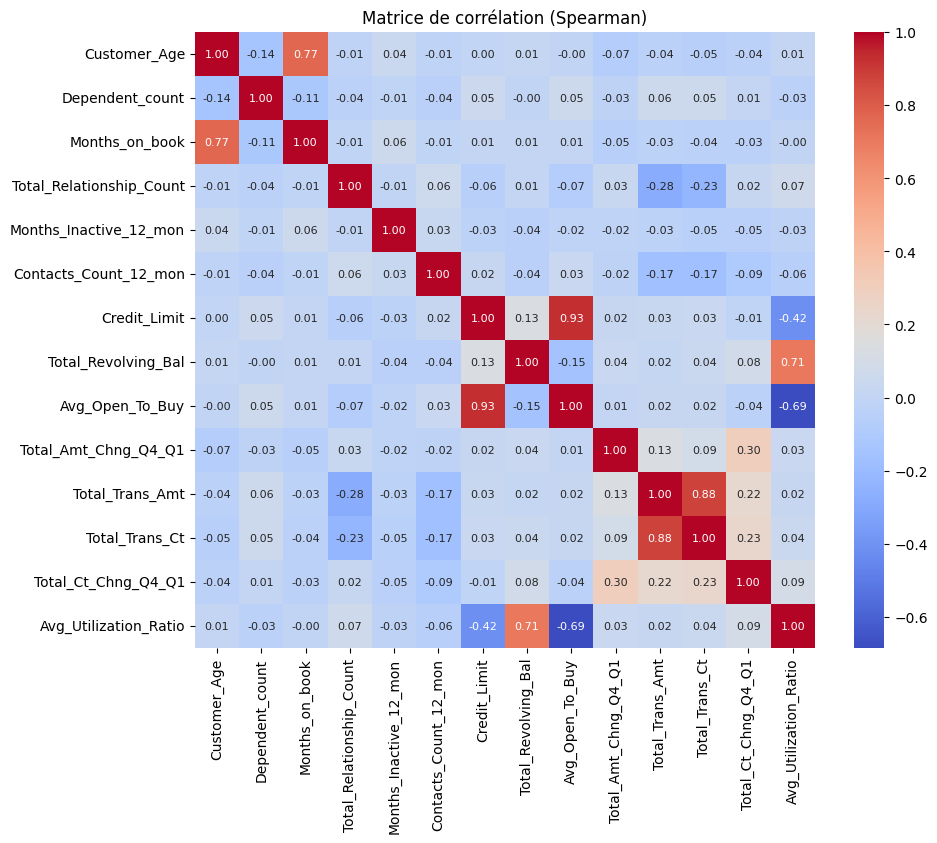

In [21]:
corr_matrix = numeric_columns.corr(method='spearman') 

plt.figure(figsize=(10, 8))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
plt.title('Matrice de corrélation (Spearman)')
plt.show()

Grâce à cette représentation graphique on voit que certaines variables semblent corrélées entre elles :
* ***Month_on_book*** et ***Customer_Age*** => 0.77
* ***Total_Trans_Ct*** et ***Total_Trans_Amt*** => 0.88
* ***Total_Revolving_Bal*** et ***Avg_utilzation_Ratio*** => 0.71
* ***Avg_Open_To_Buy*** et ***Credit_Limit*** => 0.93

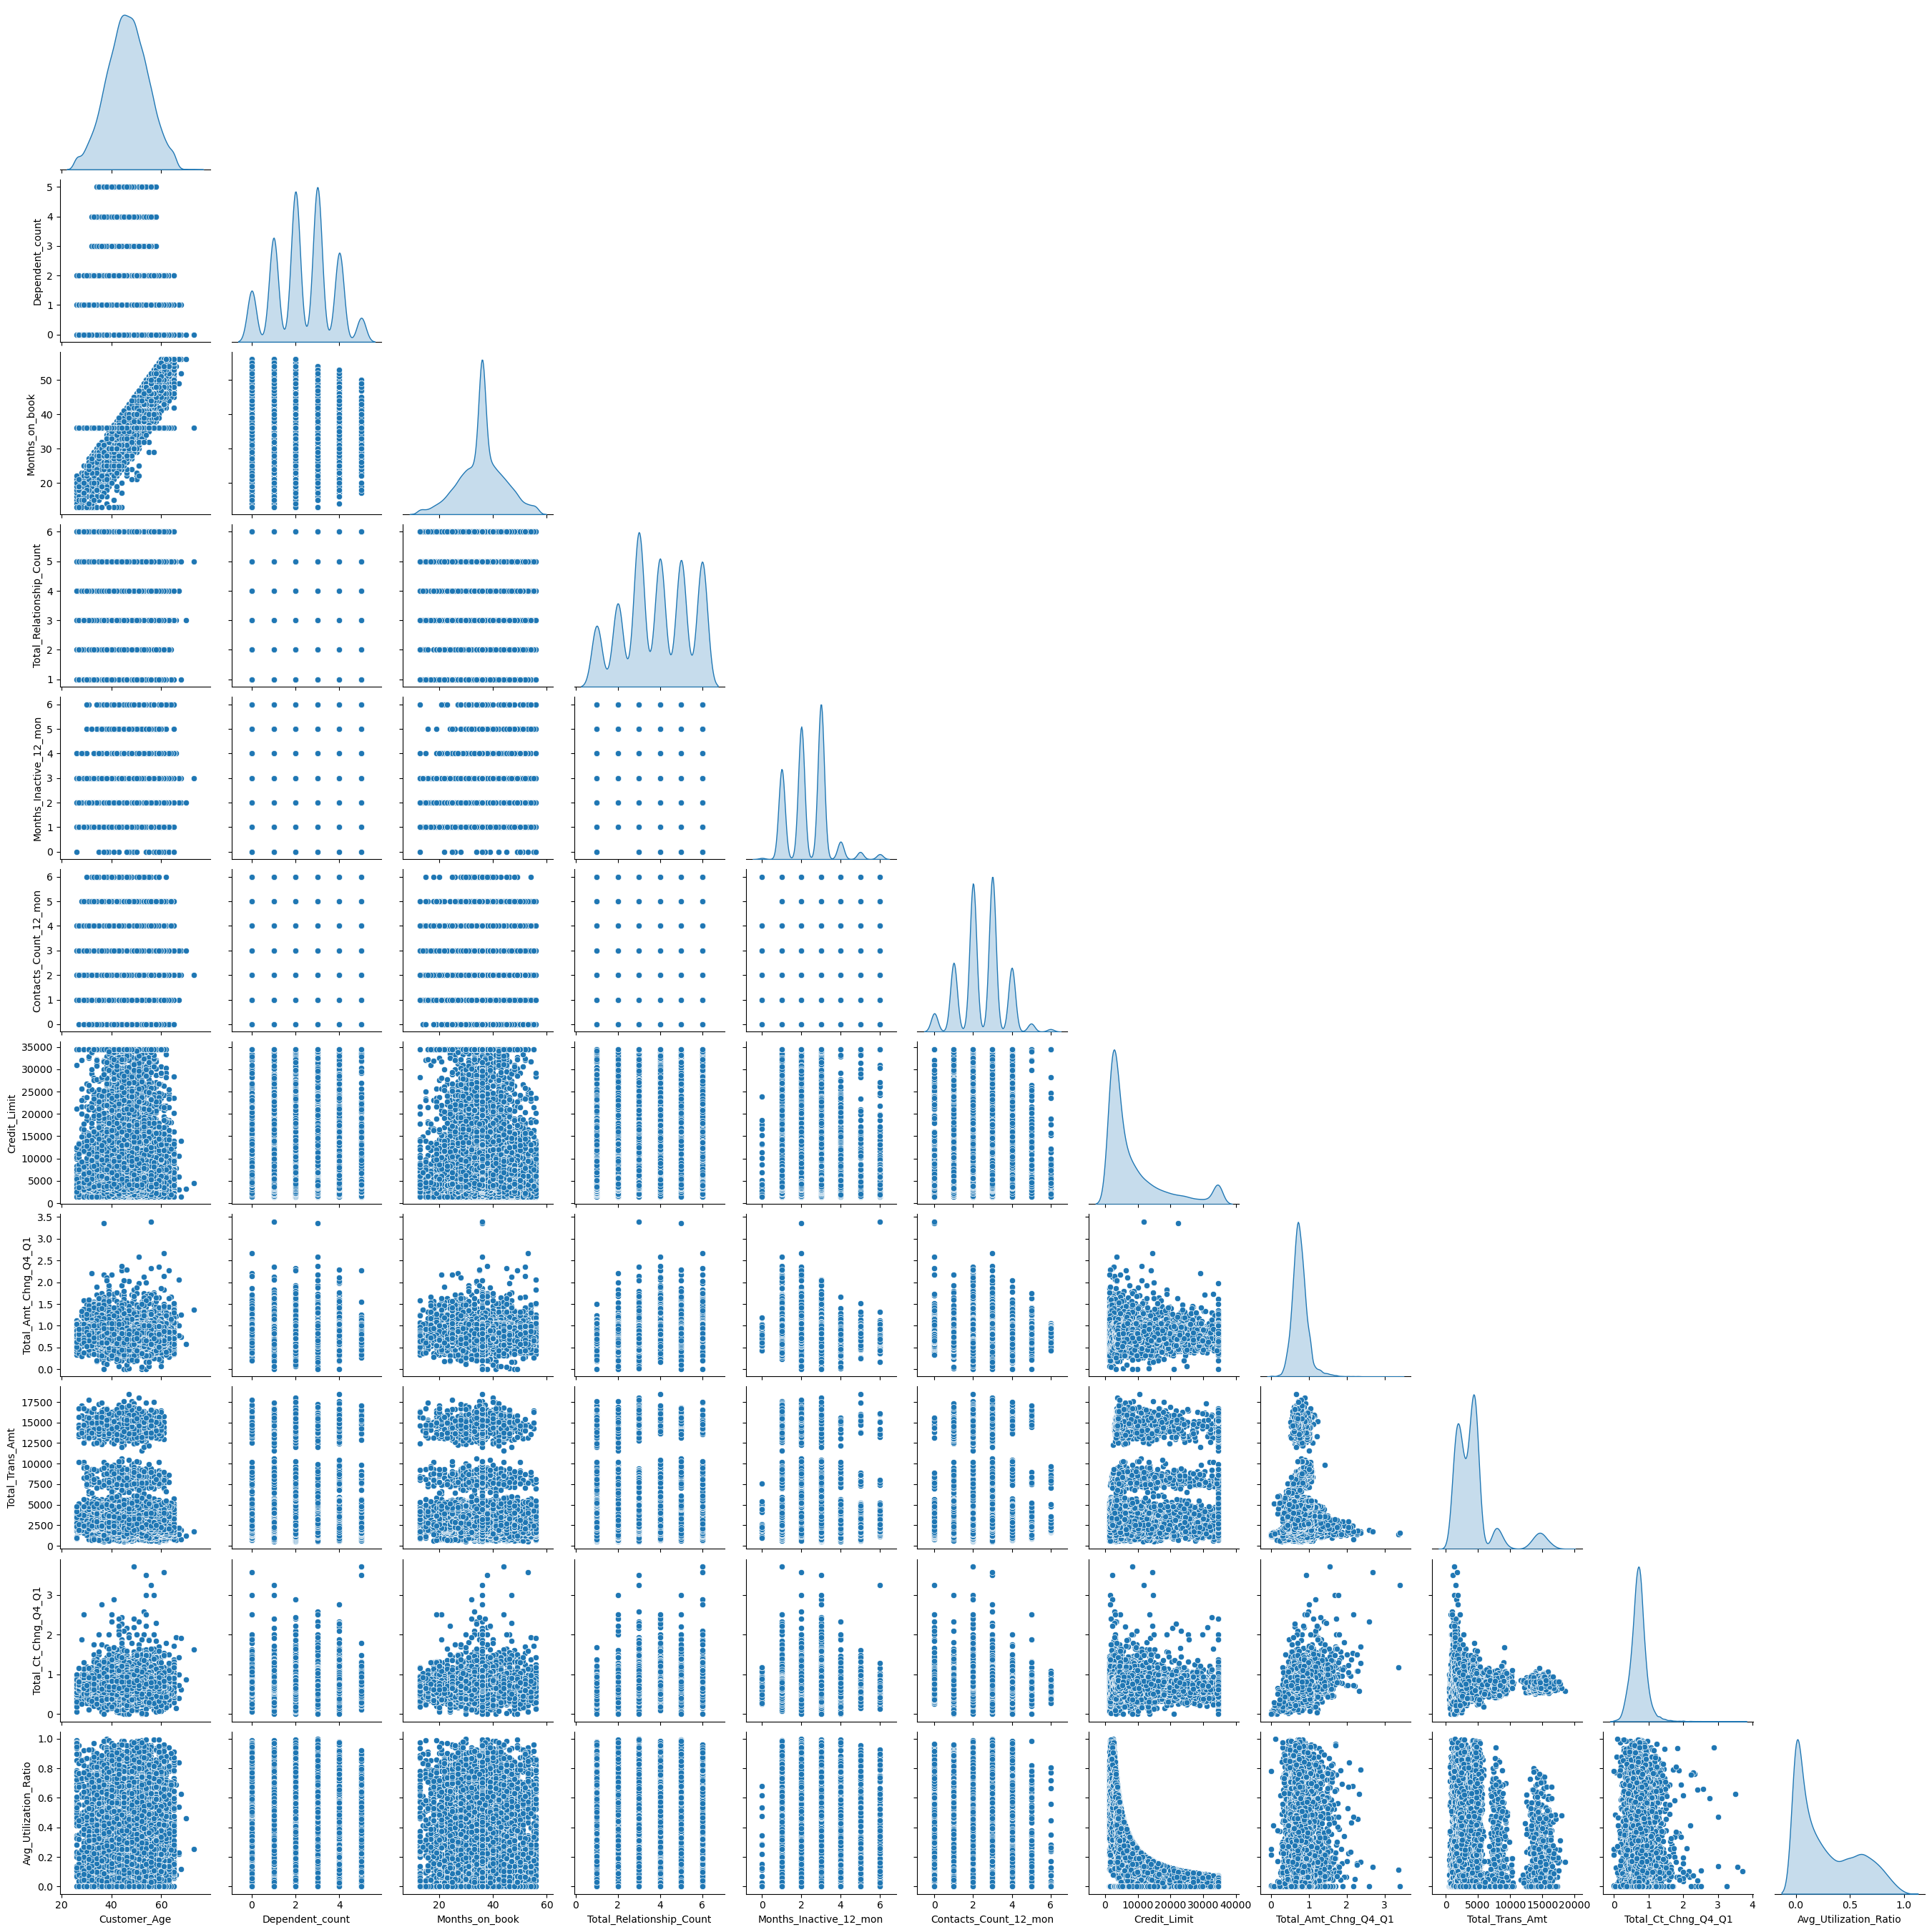

In [19]:
numeric_columns = df.select_dtypes(include=['int64', 'float64'])
sns.pairplot(numeric_columns, corner=True, diag_kind="kde")
plt.show()

On observe une relation linéaire entre `Month_On_Book` et `Customer_Age`. On verra plus tard si on supprimer une des deux variables

# 3. Preprocessing 

https://www.kaggle.com/code/rebeccapringle/bank-churners-96-6-accuracy

In [30]:
from sklearn.utils import resample
from abc import ABC, abstractmethod

class DataSplitter:
    def __init__(self, df: pd.DataFrame, target: str):
        self.df = df
        self.target = target
        self.trainset = None
        self.testset = None

    def split_data(self, test_size=0.2, random_state=42):
        self.trainset, self.testset = train_test_split(self.df, test_size=test_size, random_state=random_state, stratify=self.df[self.target])
        return self.trainset, self.testset

class Preprocessor:
    def __init__(self, trainset: pd.DataFrame, testset: pd.DataFrame, target: str):
        self.trainset = trainset
        self.testset = testset
        self.target = target
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.preprocessor = None

    def split_features_target(self):
        self.X_train = self.trainset.drop(columns=[self.target])
        self.y_train = self.trainset[self.target]
        self.X_test = self.testset.drop(columns=[self.target])
        self.y_test = self.testset[self.target]
        return self.X_train, self.X_test, self.y_train, self.y_test

    def preprocess(self, numeric_features: list, categorical_features: list):
        cat_transformer = Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])
        numeric_transformer = Pipeline(steps=[
            ('MinMAX', MinMaxScaler()), 
            ('quantil', QuantileTransformer())
        ])
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('MinMax_Q', numeric_transformer, numeric_features),
                ('OHE', cat_transformer, categorical_features)
            ],
            remainder='passthrough'
        )
        pipeline = Pipeline(steps=[('preprocessor', self.preprocessor)])
        self.X_train = pipeline.fit_transform(self.X_train)
        self.X_test = pipeline.transform(self.X_test)

        return self.X_train, self.X_test

    def get_feature_names(self):
        if self.preprocessor is None:
            raise ValueError("Preprocessor has not been applied. Please run preprocess method first.")
        
        feature_names = self.preprocessor.get_feature_names_out()

        return feature_names

class Balancer(ABC):
    def __init__(self, trainset: pd.DataFrame, target: str):
        self.trainset = trainset
        self.target = target

    @abstractmethod
    def balance(self, ratio=1.0):
        pass

class UnderSampler(Balancer):
    def balance(self, ratio=1.0):
        majority_class = self.trainset[self.trainset[self.target] == self.trainset[self.target].value_counts().idxmax()]
        minority_class = self.trainset[self.trainset[self.target] == self.trainset[self.target].value_counts().idxmin()]
        n_majority = int(len(minority_class) * ratio)
        majority_class_undersampled = resample(majority_class, replace=False, n_samples=n_majority, random_state=42)
        balanced_df = pd.concat([minority_class, majority_class_undersampled])
        return balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

class OverSampler(Balancer):
    def balance(self, ratio=1.0):
        majority_class = self.trainset[self.trainset[self.target] == self.trainset[self.target].value_counts().idxmax()]
        minority_class = self.trainset[self.trainset[self.target] == self.trainset[self.target].value_counts().idxmin()]
        n_minority = int(len(majority_class) * ratio)
        minority_class_oversampled = resample(minority_class, replace=True, n_samples=n_minority, random_state=42)
        balanced_df = pd.concat([majority_class, minority_class_oversampled])
        return balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [42]:
# Étape de découpage des données
target = 'Attrition_Flag'

splitter = DataSplitter(df, target)
trainset, testset = splitter.split_data()

In [43]:
print(trainset[target].value_counts(normalize=True))
print()
print(trainset[target].value_counts())

Attrition_Flag
Existing Customer    0.839279
Attrited Customer    0.160721
Name: proportion, dtype: float64

Attrition_Flag
Existing Customer    6799
Attrited Customer    1302
Name: count, dtype: int64


In [44]:
# Étape de prétraitement
preprocessor = Preprocessor(trainset, testset, target) 
X_train, X_test, y_train, y_test = preprocessor.split_features_target()

In [45]:
numeric_features = X_train.select_dtypes(include=['int', 'float']).columns.tolist()
numeric_features.remove("CLIENTNUM")
categorical_features = X_train.select_dtypes(include=['category', 'object']).columns.tolist()

X_train_trans, X_test_trans = preprocessor.preprocess(numeric_features=numeric_features, categorical_features=categorical_features)

In [46]:
categorical_features

['Gender',
 'Education_Level',
 'Marital_Status',
 'Income_Category',
 'Card_Category']

In [47]:
X_train_trans.shape, X_test_trans.shape, y_train.shape, y_test.shape

((8101, 38), (2026, 38), (8101,), (2026,))

In [48]:
# Obtenir les noms des fonctionnalités
feature_names = preprocessor.get_feature_names()
feature_names

array(['MinMax_Q__Customer_Age', 'MinMax_Q__Dependent_count',
       'MinMax_Q__Months_on_book', 'MinMax_Q__Total_Relationship_Count',
       'MinMax_Q__Months_Inactive_12_mon',
       'MinMax_Q__Contacts_Count_12_mon', 'MinMax_Q__Credit_Limit',
       'MinMax_Q__Total_Revolving_Bal', 'MinMax_Q__Avg_Open_To_Buy',
       'MinMax_Q__Total_Amt_Chng_Q4_Q1', 'MinMax_Q__Total_Trans_Amt',
       'MinMax_Q__Total_Trans_Ct', 'MinMax_Q__Total_Ct_Chng_Q4_Q1',
       'MinMax_Q__Avg_Utilization_Ratio', 'OHE__Gender_F',
       'OHE__Gender_M', 'OHE__Education_Level_College',
       'OHE__Education_Level_Doctorate', 'OHE__Education_Level_Graduate',
       'OHE__Education_Level_High School',
       'OHE__Education_Level_Post-Graduate',
       'OHE__Education_Level_Uneducated', 'OHE__Education_Level_Unknown',
       'OHE__Marital_Status_Divorced', 'OHE__Marital_Status_Married',
       'OHE__Marital_Status_Single', 'OHE__Marital_Status_Unknown',
       'OHE__Income_Category_$120K +', 'OHE__Income_Catego

In [49]:
# Créé des dataframe intermédiaires pour avoir les colonnes transformées
X_train_trans_df = pd.DataFrame(X_train_trans, columns=feature_names)
X_test_trans_df = pd.DataFrame(X_test_trans, columns=feature_names)

In [50]:
X_train_trans = np.array(X_train_trans_df.drop(["remainder__CLIENTNUM"], axis=1))
X_test_trans = np.array(X_test_trans_df.drop(["remainder__CLIENTNUM"], axis=1))

In [51]:
X_train_trans_df.iloc[10]

MinMax_Q__Customer_Age                 2.167167e-01
MinMax_Q__Dependent_count              1.781782e-01
MinMax_Q__Months_on_book               2.317317e-01
MinMax_Q__Total_Relationship_Count     3.243243e-01
MinMax_Q__Months_Inactive_12_mon       7.387387e-01
MinMax_Q__Contacts_Count_12_mon        9.099099e-01
MinMax_Q__Credit_Limit                 8.335030e-01
MinMax_Q__Total_Revolving_Bal          4.704705e-01
MinMax_Q__Avg_Open_To_Buy              8.319015e-01
MinMax_Q__Total_Amt_Chng_Q4_Q1         1.121121e-01
MinMax_Q__Total_Trans_Amt              4.604605e-02
MinMax_Q__Total_Trans_Ct               8.558559e-02
MinMax_Q__Total_Ct_Chng_Q4_Q1          1.701702e-01
MinMax_Q__Avg_Utilization_Ratio        3.563564e-01
OHE__Gender_F                          1.000000e+00
OHE__Gender_M                          0.000000e+00
OHE__Education_Level_College           0.000000e+00
OHE__Education_Level_Doctorate         0.000000e+00
OHE__Education_Level_Graduate          0.000000e+00
OHE__Educati

In [52]:
X_train.iloc[10]

CLIENTNUM                     715210308
Customer_Age                         40
Gender                                F
Dependent_count                       1
Education_Level             High School
Marital_Status                  Married
Income_Category                 Unknown
Card_Category                      Blue
Months_on_book                       31
Total_Relationship_Count              3
Months_Inactive_12_mon                3
Contacts_Count_12_mon                 4
Credit_Limit                    15970.0
Total_Revolving_Bal                1212
Avg_Open_To_Buy                 14758.0
Total_Amt_Chng_Q4_Q1              0.542
Total_Trans_Amt                    1260
Total_Trans_Ct                       32
Total_Ct_Chng_Q4_Q1               0.524
Avg_Utilization_Ratio             0.076
Name: 1015, dtype: object

In [56]:
X_train_trans.shape, X_test_trans.shape

((8101, 37), (2026, 37))

In [57]:
y_train = y_train.map({'Attrited Customer': 1, 'Existing Customer': 0})
y_test = y_test.map({'Attrited Customer': 1, 'Existing Customer': 0})

# Procédure d'évaluation :

In [58]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve 
from sklearn.metrics import confusion_matrix, classification_report 
from collections import Counter

class ModelEvaluator:
    def __init__(self, models, X_train, y_train, X_test, y_test, cv_splits=3, sample_size=0.1):
        self.models = models
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.cv_splits = cv_splits
        self.sample_size = sample_size
        self.scores = {"precision": {}, "recall": {}, "f1": {}}
    
    def evaluate_models(self):
        # Use a sample of the training data if specified
        if self.sample_size < 1.0:
            self.X_train, self.y_train = resample(self.X_train, self.y_train, 
                                                  n_samples=int(len(self.X_train) * self.sample_size),
                                                  random_state=42)
        
        for name, model in self.models.items():
            print(f"Evaluating {name}...")
            # Fit the model
            model.fit(self.X_train, self.y_train)
            # Cross-validate and collect scores
            precision_scores = cross_val_score(model, self.X_train, self.y_train, 
                                               cv=self.cv_splits, scoring='precision', n_jobs=-1)
            recall_scores = cross_val_score(model, self.X_train, self.y_train, 
                                            cv=self.cv_splits, scoring='recall', n_jobs=-1)
            f1_scores = cross_val_score(model, self.X_train, self.y_train, 
                                        cv=self.cv_splits, scoring='f1', n_jobs=-1)
            
            self.scores["precision"][name] = precision_scores
            self.scores["recall"][name] = recall_scores
            self.scores["f1"][name] = f1_scores
            
            # Print classification report
            y_pred = model.predict(self.X_test)
            print(confusion_matrix(self.y_test, y_pred))
            print(classification_report(self.y_test, y_pred))
        
    def plot_results(self):
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Plot precision scores
        axes[0].boxplot(self.scores["precision"].values(), labels=self.scores["precision"].keys())
        axes[0].set_title('Precision Scores')
        axes[0].set_ylabel('Score')
        
        # Plot recall scores
        axes[1].boxplot(self.scores["recall"].values(), labels=self.scores["recall"].keys())
        axes[1].set_title('Recall Scores')
        axes[1].set_ylabel('Score')
        
        # Plot f1 scores
        axes[2].boxplot(self.scores["f1"].values(), labels=self.scores["f1"].keys())
        axes[2].set_title('F1 Scores')
        axes[2].set_ylabel('Score')
        
        plt.tight_layout()
        plt.show()

class FeatureImportanceAnalyzer:
    def __init__(self, models, X_train):
        self.models = models
        self.X_train = X_train
        self.feature_importances = {model: {} for model in models.keys()}
    
    def analyze_feature_importance(self):
        for name, model in self.models.items():
            if hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
            elif hasattr(model, 'coef_'):
                importances = model.coef_[0]
            else:
                continue
            sorted_indices = np.argsort(importances)[::-1]
            top_features = sorted_indices[:8]
            self.feature_importances[name] = {self.X_train.columns[i]: importances[i] for i in top_features}
        
    def plot_feature_importance(self):
        all_importances = Counter()
        for model, importances in self.feature_importances.items():
            for feature, importance in importances.items():
                all_importances[feature] += 1
        
        most_common_features = all_importances.most_common()
        feature_names = [item[0] for item in most_common_features]
        counts = [item[1] for item in most_common_features]
        
        plt.figure(figsize=(12, 8))
        plt.barh(feature_names, counts)
        plt.xlabel('Importance Count')
        plt.ylabel('Features')
        plt.title('Most Important Features Across Models')
        plt.gca().invert_yaxis()
        plt.show()

class ModelAnalyzer:
    def __init__(self, model, X_train, y_train, X_test, y_test):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

    def evaluation(self):
        self.model.fit(self.X_train, self.y_train)
        y_pred = self.model.predict(self.X_test)

        print(confusion_matrix(self.y_test, y_pred))
        print(classification_report(self.y_test, y_pred))

        skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)
        N, train_score, val_score = learning_curve(self.model, self.X_train, self.y_train,
                                                   cv=skf, scoring='f1',
                                                   train_sizes=np.linspace(0.1, 1, 10))

        plt.figure(figsize=(12, 8))
        plt.plot(N, train_score.mean(axis=1), label='train score')
        plt.plot(N, val_score.mean(axis=1), label='validation score')
        plt.legend()
        plt.xlabel('Training Size')
        plt.ylabel('Score')
        plt.title('Learning Curve')
        plt.show()


In [59]:
# Définir les modèles
models = {
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBClassifier': xgb.XGBClassifier(random_state=42, n_jobs=-1),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Support Vector Machine': SVC(random_state=42)
    }

In [60]:
# Évaluer les modèles
evaluator = ModelEvaluator(models, X_train_trans, y_train, X_test_trans, y_test, cv_splits=5, sample_size=1)
evaluator.evaluate_models()

Evaluating GradientBoosting...
[[1679   22]
 [  49  276]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1701
           1       0.93      0.85      0.89       325

    accuracy                           0.96      2026
   macro avg       0.95      0.92      0.93      2026
weighted avg       0.96      0.96      0.96      2026

Evaluating XGBClassifier...
[[1677   24]
 [  33  292]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1701
           1       0.92      0.90      0.91       325

    accuracy                           0.97      2026
   macro avg       0.95      0.94      0.95      2026
weighted avg       0.97      0.97      0.97      2026

Evaluating AdaBoost...
[[1665   36]
 [  48  277]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1701
           1       0.88      0.85      0.87       325

    accuracy       

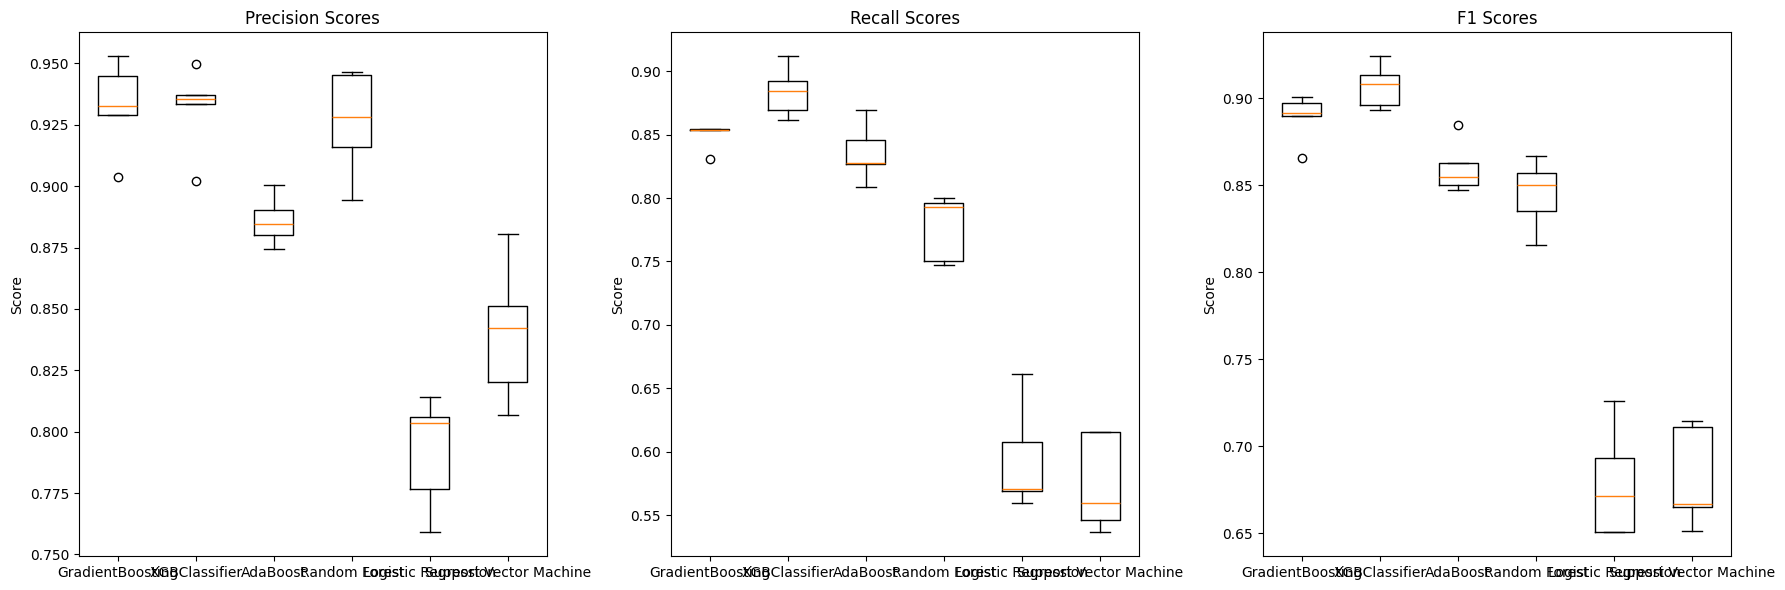

In [61]:
evaluator.plot_results()

A tester : XGBClassifier et GradientBoostingClassifier

In [62]:
# Analyser les importances des fonctionnalités 
analyzer = FeatureImportanceAnalyzer(models, X_train_trans_df)
analyzer.analyze_feature_importance()

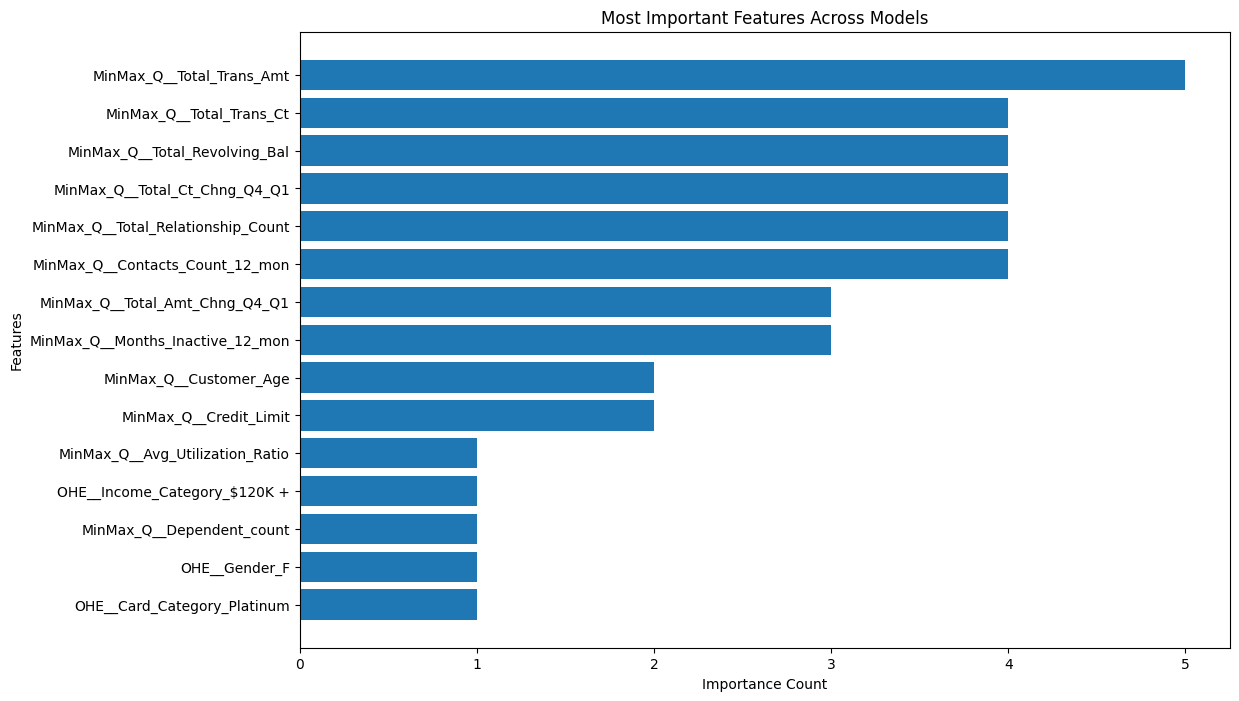

In [63]:
analyzer.plot_feature_importance()

# Test des modèles pré-séléctionnés

[[1677   24]
 [  33  292]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1701
           1       0.92      0.90      0.91       325

    accuracy                           0.97      2026
   macro avg       0.95      0.94      0.95      2026
weighted avg       0.97      0.97      0.97      2026



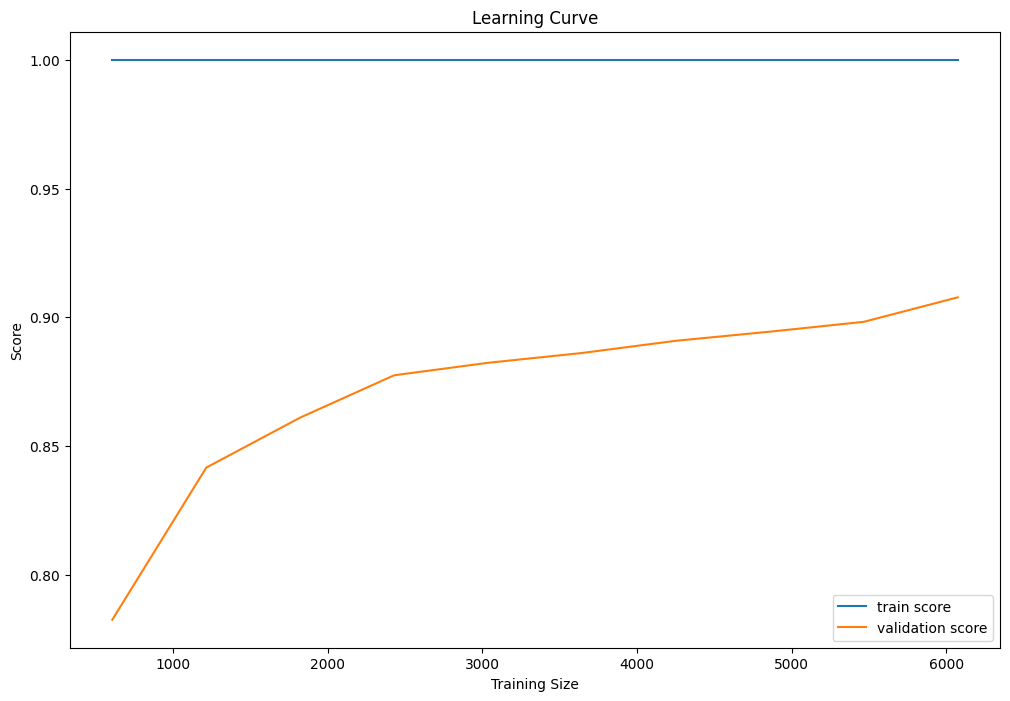

In [64]:
chosen_model = xgb.XGBClassifier(random_state=42, n_jobs=-1) 
model_analyzer = ModelAnalyzer(chosen_model, X_train_trans, y_train, X_test_trans, y_test)
model_analyzer.evaluation()

=> OverFitting mais bonnes perfs du validation score

[[1679   22]
 [  49  276]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1701
           1       0.93      0.85      0.89       325

    accuracy                           0.96      2026
   macro avg       0.95      0.92      0.93      2026
weighted avg       0.96      0.96      0.96      2026



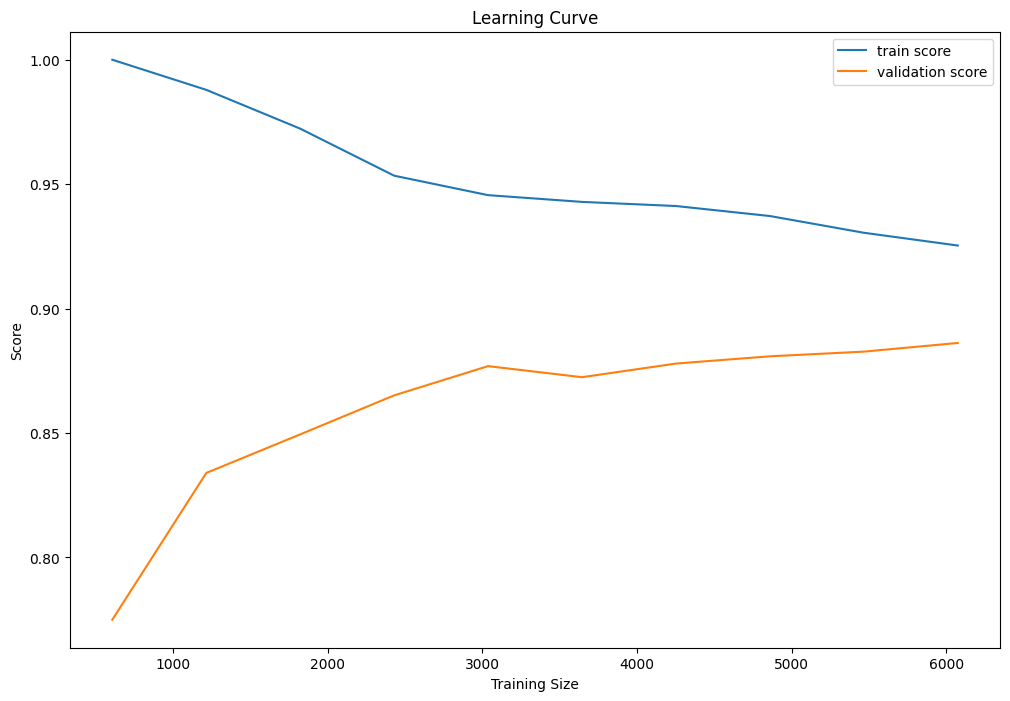

In [65]:
chosen_model2 = GradientBoostingClassifier(random_state=42) 
model_analyzer = ModelAnalyzer(chosen_model2, X_train_trans, y_train, X_test_trans, y_test)
model_analyzer.evaluation()

=> Bons résultats, peut être amélioré avec de meilleurs hyperparamètres

## Nouveau modèle a partir des best features :

In [87]:
df2 = df[["Contacts_Count_12_mon",
        "Total_Relationship_Count",
        "Total_Amt_Chng_Q4_Q1",
        "Total_Ct_Chng_Q4_Q1",
        "Total_Revolving_Bal",
        "Total_Trans_Ct",
        "Total_Trans_Amt",
        "Months_Inactive_12_mon",
        "Customer_Age", 
        'Attrition_Flag',
        "CLIENTNUM"]]

In [88]:
# Étape de découpage des données
target = 'Attrition_Flag'

splitter2 = DataSplitter(df2, target)
trainset, testset = splitter2.split_data()

In [89]:
print(trainset[target].value_counts(normalize=True))
print()
print(trainset[target].value_counts())

Attrition_Flag
Existing Customer    0.839279
Attrited Customer    0.160721
Name: proportion, dtype: float64

Attrition_Flag
Existing Customer    6799
Attrited Customer    1302
Name: count, dtype: int64


In [90]:
# Étape de prétraitement
preprocessor = Preprocessor(trainset, testset, target) 
X_train, X_test, y_train, y_test = preprocessor.split_features_target()

In [91]:
numeric_features = X_train.select_dtypes(include=['int', 'float']).columns.tolist()
numeric_features.remove("CLIENTNUM")
categorical_features = X_train.select_dtypes(include=['category', 'object']).columns.tolist()

X_train_trans, X_test_trans = preprocessor.preprocess(numeric_features=numeric_features, categorical_features=categorical_features)

In [92]:
categorical_features

[]

In [93]:
X_train_trans.shape, X_test_trans.shape, y_train.shape, y_test.shape

((8101, 10), (2026, 10), (8101,), (2026,))

In [94]:
# Obtenir les noms des fonctionnalités
feature_names = preprocessor.get_feature_names()
feature_names

array(['MinMax_Q__Contacts_Count_12_mon',
       'MinMax_Q__Total_Relationship_Count',
       'MinMax_Q__Total_Amt_Chng_Q4_Q1', 'MinMax_Q__Total_Ct_Chng_Q4_Q1',
       'MinMax_Q__Total_Revolving_Bal', 'MinMax_Q__Total_Trans_Ct',
       'MinMax_Q__Total_Trans_Amt', 'MinMax_Q__Months_Inactive_12_mon',
       'MinMax_Q__Customer_Age', 'remainder__CLIENTNUM'], dtype=object)

In [95]:
# Créé des dataframe intermédiaires pour avoir les colonnes transformées
X_train_trans_df = pd.DataFrame(X_train_trans, columns=feature_names)
X_test_trans_df = pd.DataFrame(X_test_trans, columns=feature_names)

In [96]:
X_train_trans = np.array(X_train_trans_df.drop(["remainder__CLIENTNUM"], axis=1))
X_test_trans = np.array(X_test_trans_df.drop(["remainder__CLIENTNUM"], axis=1))

In [97]:
# Visualisation de XGB par défaut
xgb_default2 = xgb.XGBClassifier(n_jobs=-1, random_state=0)

In [99]:
y_train = y_train.map({'Attrited Customer': 1, 'Existing Customer': 0})
y_test = y_test.map({'Attrited Customer': 1, 'Existing Customer': 0})

[[1673   28]
 [  35  290]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1701
           1       0.91      0.89      0.90       325

    accuracy                           0.97      2026
   macro avg       0.95      0.94      0.94      2026
weighted avg       0.97      0.97      0.97      2026



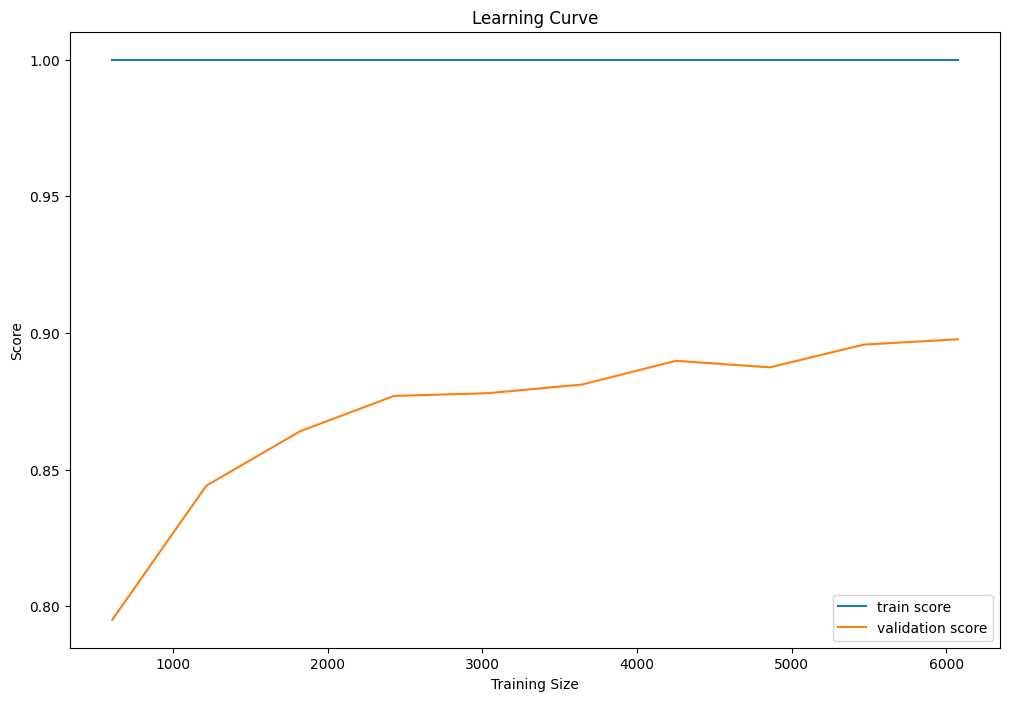

In [100]:
model_analyzer = ModelAnalyzer(xgb_default2, X_train_trans, y_train, X_test_trans, y_test)
model_analyzer.evaluation()

=> Hyperparamètres à améliorer !

In [101]:
gb_default = GradientBoostingClassifier(random_state=42)

[[1678   23]
 [  49  276]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1701
           1       0.92      0.85      0.88       325

    accuracy                           0.96      2026
   macro avg       0.95      0.92      0.93      2026
weighted avg       0.96      0.96      0.96      2026



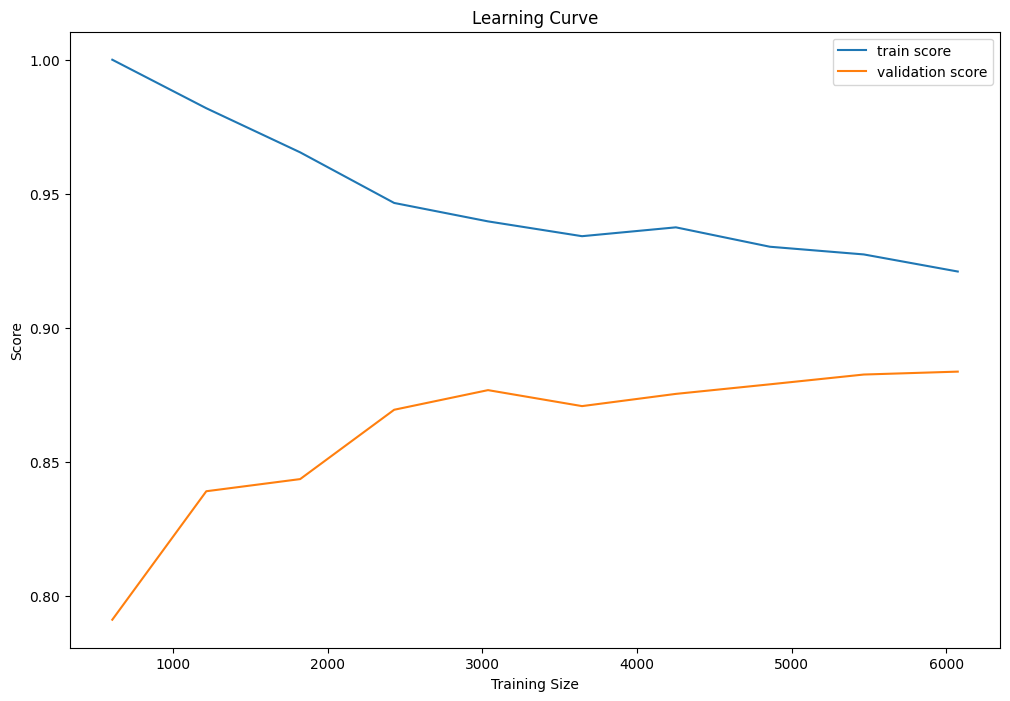

In [102]:
model_analyzer = ModelAnalyzer(gb_default, X_train_trans, y_train, X_test_trans, y_test)
model_analyzer.evaluation()

=> Performances quasiement similaires, cela montre que les autres variables n'apportent rien au modèle. On va garder ces variables pour gagner en temps de calculs

# Optuna XGB

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

train_x, val_x, train_y, val_y = train_test_split(X_train_trans, y_train, train_size=0.7, random_state=1)

In [295]:
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': 'gbtree',
        'max_depth': trial.suggest_int('max_depth', 1, 3),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'seed': 42
    }

    model = xgb.XGBClassifier(**param)

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    fit_params = {
        'verbose': False,
        'eval_set': [(val_x, val_y)],
        'early_stopping_rounds': 10  
    }
    f1 = cross_val_score(model, X_train_trans, y_train, cv=skf, scoring=make_scorer(f1_score), fit_params=fit_params).mean()

    return f1


In [296]:
import optuna
from optuna.samplers import TPESampler

sampler = TPESampler(seed = 0) # Bayésien
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=200)

[I 2024-07-17 20:46:07,327] A new study created in memory with name: no-name-b97ccc3c-11cc-4211-9be1-3ffcba0dfb2f
[I 2024-07-17 20:46:09,095] Trial 0 finished with value: 0.8992992962361337 and parameters: {'max_depth': 2, 'learning_rate': 0.21740491624800165, 'n_estimators': 201, 'subsample': 0.7724415914984484, 'colsample_bytree': 0.7118273996694524, 'min_child_weight': 7, 'reg_alpha': 3.167361913032263e-05, 'reg_lambda': 0.13620216352659412}. Best is trial 0 with value: 0.8992992962361337.
[I 2024-07-17 20:46:11,905] Trial 1 finished with value: 0.8962820112227637 and parameters: {'max_depth': 3, 'learning_rate': 0.12119804045947552, 'n_estimators': 248, 'subsample': 0.7644474598764522, 'colsample_bytree': 0.7840222805469661, 'min_child_weight': 10, 'reg_alpha': 3.70073907377613e-08, 'reg_lambda': 4.9777650902423137e-08}. Best is trial 0 with value: 0.8992992962361337.
[I 2024-07-17 20:46:13,629] Trial 2 finished with value: 0.8660055768285269 and parameters: {'max_depth': 1, 'learn

In [297]:
print('Best trial:')
trial = study.best_trial
print('precision: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Best trial:
precision: 0.9142847935943259
Best hyperparameters: {'max_depth': 3, 'learning_rate': 0.10784525613941554, 'n_estimators': 274, 'subsample': 0.8766609655185922, 'colsample_bytree': 0.5559101287300079, 'min_child_weight': 2, 'reg_alpha': 1.148922089078765e-05, 'reg_lambda': 0.0002080925720941604}


In [298]:
best_params = trial.params 
xgb_opt = xgb.XGBClassifier(**best_params)

In [104]:
xgb_opt = xgb.XGBClassifier(max_depth= 3, learning_rate= 0.10784525613941554, n_estimators= 274, subsample= 0.8766609655185922, 
                            colsample_bytree= 0.5559101287300079, min_child_weight=2, reg_alpha= 1.148922089078765e-05, reg_lambda= 0.0002080925720941604)

[[1676   25]
 [  30  295]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1701
           1       0.92      0.91      0.91       325

    accuracy                           0.97      2026
   macro avg       0.95      0.95      0.95      2026
weighted avg       0.97      0.97      0.97      2026



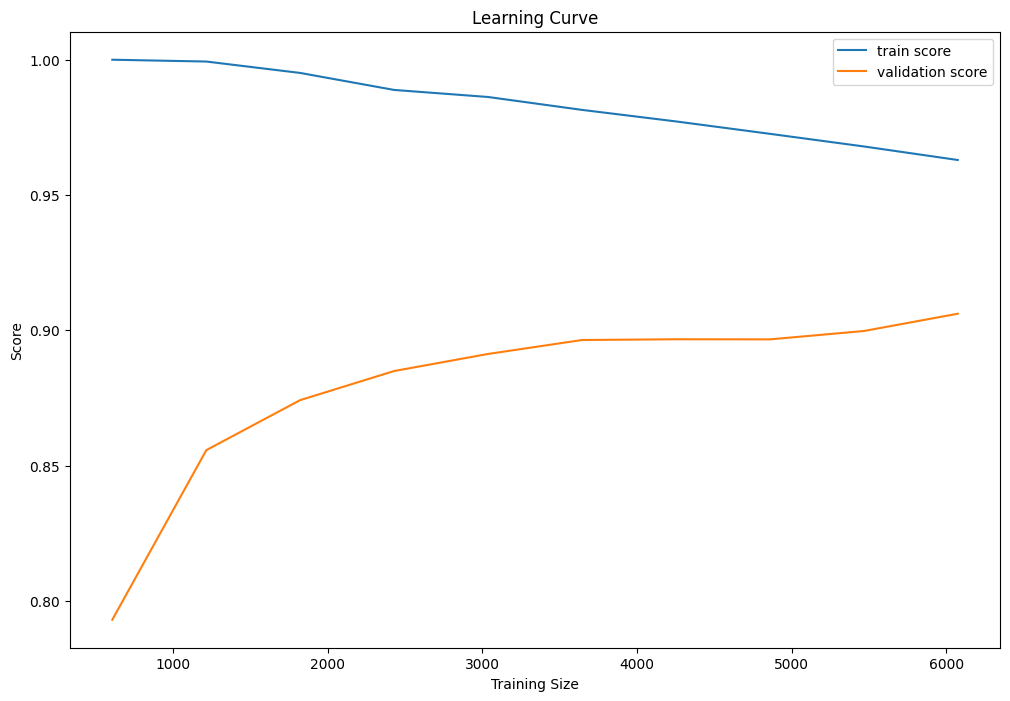

In [105]:
model_analyzer = ModelAnalyzer(xgb_opt, X_train_trans, y_train, X_test_trans, y_test)
model_analyzer.evaluation()

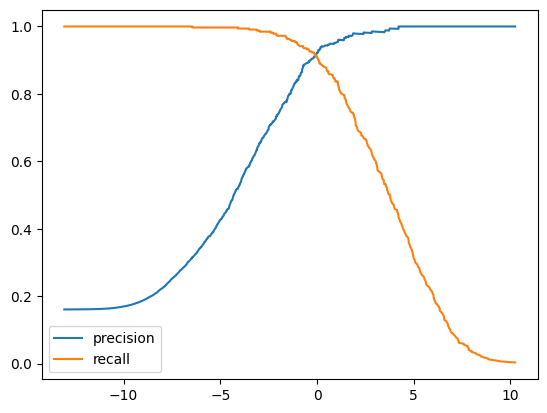

In [106]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_test, xgb_opt.predict(X_test_trans, output_margin=True))

plt.plot(threshold, precision[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='recall')
plt.legend()

In [107]:
def model_final(model, X_train_trans, threshold=0):
    return model.predict(X_test_trans, output_margin=True) > threshold

In [116]:
y_pred = model_final(xgb_opt, X_test_trans, threshold=-0.6)

In [117]:
f1_score(y_true=y_test, y_pred=y_pred)

0.9129129129129129

Test : 0.992489485822819
Train : 0.9983850521073738


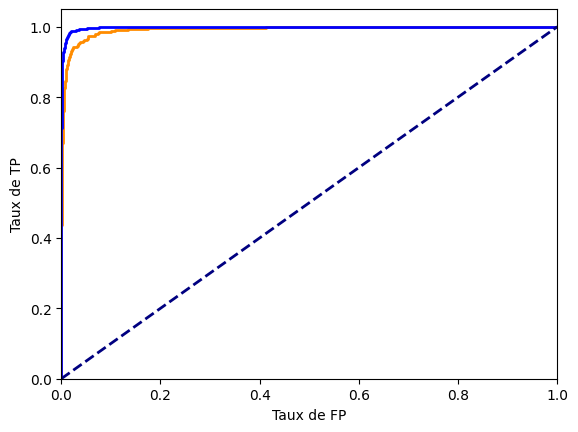

In [118]:
y_probs = xgb_opt.predict_proba(X_test_trans)[:, 1]
y_prob_train = xgb_opt.predict_proba(X_train_trans)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_probs)
fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)

roc_auc = auc(fpr, tpr)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure()
lw = 2 
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot(fpr_train, tpr_train, color='blue', lw=lw, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de FP')
plt.ylabel('Taux de TP')

print('Test :', roc_auc)
print('Train :', roc_auc_train)

In [119]:
df_results = pd.DataFrame({'y_probs' : y_probs, 'true': y_test})

df_results = df_results.sort_values(by='y_probs', ascending=False)

top_pred = df_results[0:int(len(y_test)*0.2)] # 20% des meilleures probabilités
nb_true_pos = top_pred[top_pred['true'] == 1].shape[0]
print('Parmi les 20% de meilleurs probabilités,', round(nb_true_pos / top_pred.shape[0] * 100, 2), '% de clients sont réellement souscripteurs')

Parmi les 20% de meilleurs probabilités, 77.53 % de clients sont réellement souscripteurs


In [120]:
data = pd.DataFrame({'y_true': y_test, 'y_probs': y_probs})
data = data.sort_values(by='y_probs', ascending=False).reset_index(drop=True)
data["rank"] = np.arange(1, len(data) + 1)
num_segm = 10
data["segment"] = pd.qcut(data['rank'], num_segm, labels=False)

# Convert 'y_true' to an integer data type
data['y_true'] = data['y_true'].astype(int)

lift_table = data.groupby('segment').agg({
    'y_true': ['sum', 'count']
}).reset_index()
lift_table.columns = ["segment", "sum_y_true", "count"]

In [121]:
lift_table

segment  sum_y_true  count
0        0         200    203
1        1         115    203
2        2           8    202
3        3           1    203
4        4           0    202
5        5           1    203
6        6           0    202
7        7           0    203
8        8           0    202
9        9           0    203

In [122]:
lift_table['cum_sub'] = lift_table['sum_y_true'].cumsum()
lift_table["cum_pop"] = lift_table['count'].cumsum() / len(data)

In [123]:
initial_point = pd.DataFrame({'segment': [-1], 'sum_y_true': [0], 'count': [0], 'cum_sub': [0], 'cum_pop': [0]})
lift_table = pd.concat([initial_point, lift_table]).reset_index(drop=True)

In [124]:
lift_table['perc_sub_capt_relatif'] = lift_table['cum_sub'] / lift_table['count'].cumsum()
lift_table['perc_sub_capt'] = lift_table['cum_sub'] / data['y_true'].sum()

In [125]:
lift_table

segment  sum_y_true  count  cum_sub   cum_pop  perc_sub_capt_relatif  \
0        -1           0      0        0  0.000000                    NaN   
1         0         200    203      200  0.100197               0.985222   
2         1         115    203      315  0.200395               0.775862   
3         2           8    202      323  0.300099               0.531250   
4         3           1    203      324  0.400296               0.399507   
5         4           0    202      324  0.500000               0.319842   
6         5           1    203      325  0.600197               0.267270   
7         6           0    202      325  0.699901               0.229196   
8         7           0    203      325  0.800099               0.200494   
9         8           0    202      325  0.899803               0.178278   
10        9           0    203      325  1.000000               0.160415   

    perc_sub_capt  
0        0.000000  
1        0.615385  
2        0.969231  
3        0.993846  
4        0.996923  
5        0.996923  
6        1.000000  
7        1.000000  
8        1.000000  
9        1.000000  
10       1.000000

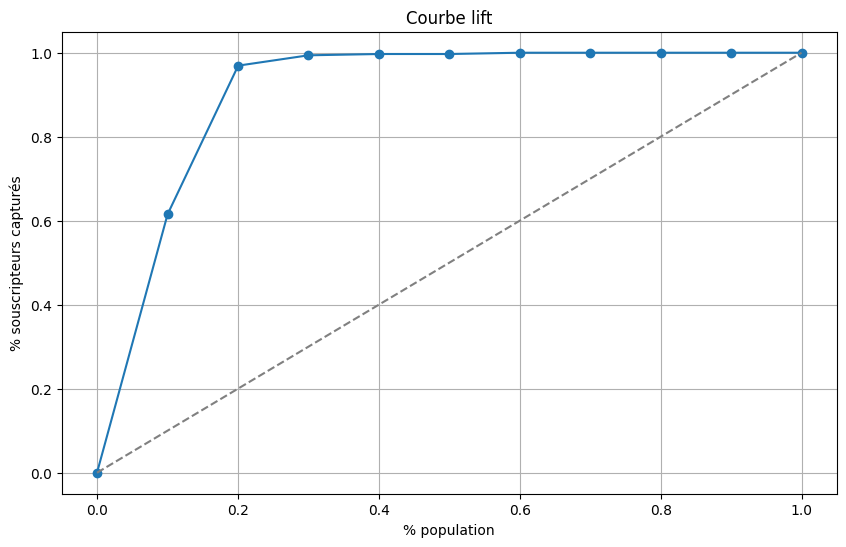

In [126]:
plt.figure(figsize=(10, 6))
x = lift_table["cum_pop"]
y = lift_table["perc_sub_capt"]

plt.plot(x, y, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.title('Courbe lift')
plt.xlabel('% population')
plt.ylabel('% souscripteurs capturés')
plt.grid(True)
plt.show()

In [127]:
def lift(lift_table, pourcentage):
    return round(lift_table[lift_table['segment'] == (20 / 10) - 1]["perc_sub_capt"] / pourcentage * 100, 2)

In [128]:
lift(lift_table=lift_table, pourcentage=20)

2    4.85
Name: perc_sub_capt, dtype: float64

# Optuna GradientBoosting :

In [131]:
def objective(trial):
    param = {
        'loss': trial.suggest_categorical('loss', ['log_loss', 'exponential']),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 3),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': 0
    }

    model = GradientBoostingClassifier(**param)

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    f1 = cross_val_score(model, X_train_trans, y_train, cv=skf, scoring=make_scorer(f1_score)).mean()

    return f1

In [132]:
import optuna
from optuna.samplers import TPESampler

sampler = TPESampler(seed = 0) # Bayésien
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2024-07-18 09:27:41,174] A new study created in memory with name: no-name-4e2e6704-9a10-4cdc-a5b5-2ca115c31e43
[I 2024-07-18 09:27:45,240] Trial 0 finished with value: 0.47219678369161056 and parameters: {'loss': 'exponential', 'learning_rate': 0.18480137906077673, 'n_estimators': 186, 'subsample': 0.7118273996694524, 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.48183138025051464, 'max_features': 'log2'}. Best is trial 0 with value: 0.47219678369161056.
[I 2024-07-18 09:27:46,671] Trial 1 finished with value: 0.5535783135691981 and parameters: {'loss': 'exponential', 'learning_rate': 0.2784230251048717, 'n_estimators': 67, 'subsample': 0.5435646498507704, 'max_depth': 1, 'min_samples_split': 17, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.4350060741234096, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5535783135691981.
[I 2024-07-18 09:27:53,336] Trial 2 finished with value: 0.8043038182519469 and parameters: {'loss'

In [133]:
print('Best trial:')
trial_2 = study.best_trial
print('precision: {}'.format(trial_2.value))
print("Best hyperparameters: {}".format(trial_2.params))

Best trial:
precision: 0.9081884850675825
Best hyperparameters: {'loss': 'log_loss', 'learning_rate': 0.11172350498446691, 'n_estimators': 291, 'subsample': 0.6436757617324871, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 9.346034371258841e-05, 'max_features': 'sqrt'}


In [134]:
best_params = trial_2.params 
gb_opt = GradientBoostingClassifier(**best_params)

[[1678   23]
 [  34  291]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1701
           1       0.93      0.90      0.91       325

    accuracy                           0.97      2026
   macro avg       0.95      0.94      0.95      2026
weighted avg       0.97      0.97      0.97      2026



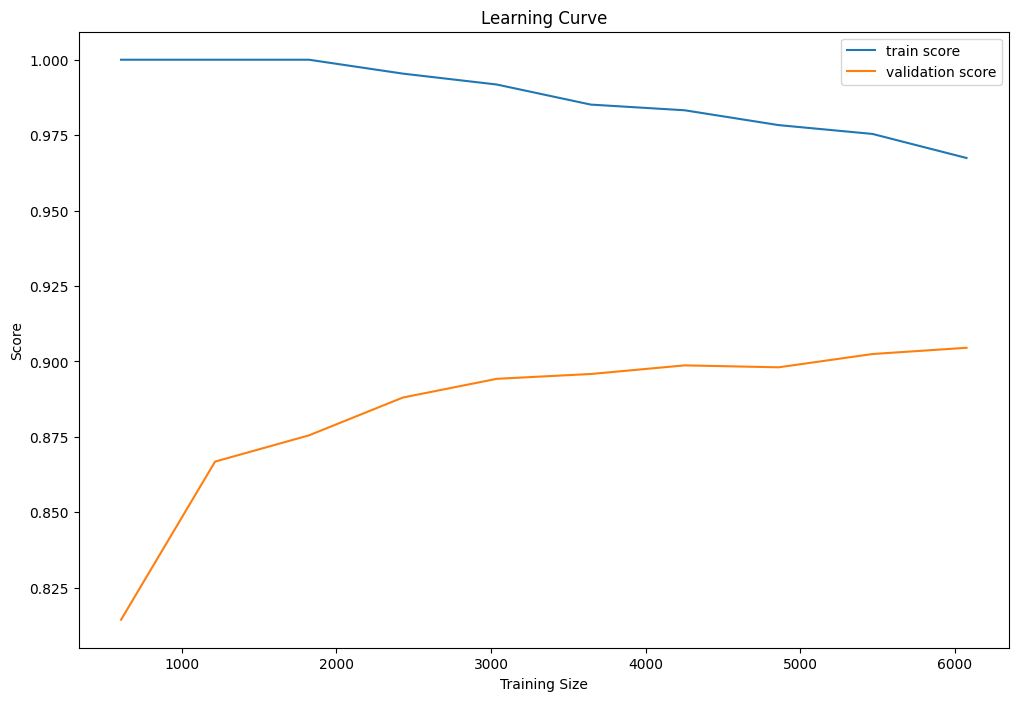

In [135]:
model_analyzer = ModelAnalyzer(gb_opt, X_train_trans, y_train, X_test_trans, y_test)
model_analyzer.evaluation()

In [136]:
optuna.visualization.plot_param_importances(study)

In [137]:
optuna.visualization.plot_optimization_history(study)

Test : 0.9914964048297381
Train : 0.9986992078215171


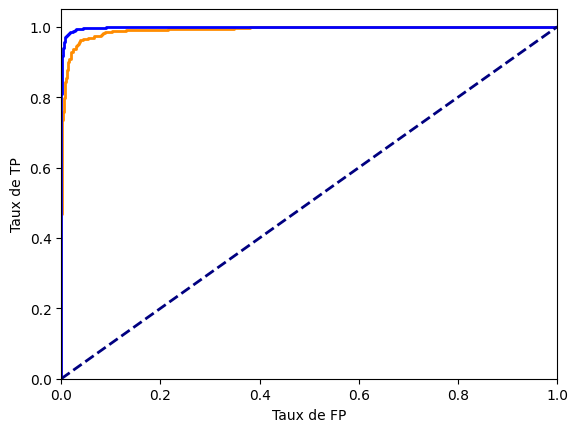

In [138]:
y_probs = gb_opt.predict_proba(X_test_trans)[:, 1]
y_prob_train = gb_opt.predict_proba(X_train_trans)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_probs)
fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)

roc_auc = auc(fpr, tpr)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure()
lw = 2 
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot(fpr_train, tpr_train, color='blue', lw=lw, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de FP')
plt.ylabel('Taux de TP')

print('Test :', roc_auc)
print('Train :', roc_auc_train)

In [139]:
df_results = pd.DataFrame({'y_probs' : y_probs, 'true': y_test})

df_results = df_results.sort_values(by='y_probs', ascending=False)

top_pred = df_results[0:int(len(y_test)*0.2)] # 20% des meilleures probabilités
nb_true_pos = top_pred[top_pred['true'] == 1].shape[0]
print('Parmi les 20% de meilleurs probabilités,', round(nb_true_pos / top_pred.shape[0] * 100, 2), '% de clients sont réellement souscripteurs')

Parmi les 20% de meilleurs probabilités, 77.53 % de clients sont réellement souscripteurs


In [140]:
data = pd.DataFrame({'y_true': y_test, 'y_probs': y_probs})
data = data.sort_values(by='y_probs', ascending=False).reset_index(drop=True)
data["rank"] = np.arange(1, len(data) + 1)
num_segm = 10
data["segment"] = pd.qcut(data['rank'], num_segm, labels=False)

# Convert 'y_true' to an integer data type
data['y_true'] = data['y_true'].astype(int)

lift_table = data.groupby('segment').agg({
    'y_true': ['sum', 'count']
}).reset_index()
lift_table.columns = ["segment", "sum_y_true", "count"]

In [141]:
lift_table

segment  sum_y_true  count
0        0         201    203
1        1         114    203
2        2           7    202
3        3           1    203
4        4           2    202
5        5           0    203
6        6           0    202
7        7           0    203
8        8           0    202
9        9           0    203

In [142]:
lift_table['cum_sub'] = lift_table['sum_y_true'].cumsum()
lift_table["cum_pop"] = lift_table['count'].cumsum() / len(data)

In [143]:
initial_point = pd.DataFrame({'segment': [-1], 'sum_y_true': [0], 'count': [0], 'cum_sub': [0], 'cum_pop': [0]})
lift_table = pd.concat([initial_point, lift_table]).reset_index(drop=True)

In [144]:
lift_table['perc_sub_capt_relatif'] = lift_table['cum_sub'] / lift_table['count'].cumsum()
lift_table['perc_sub_capt'] = lift_table['cum_sub'] / data['y_true'].sum()

In [145]:
lift_table

segment  sum_y_true  count  cum_sub   cum_pop  perc_sub_capt_relatif  \
0        -1           0      0        0  0.000000                    NaN   
1         0         201    203      201  0.100197               0.990148   
2         1         114    203      315  0.200395               0.775862   
3         2           7    202      322  0.300099               0.529605   
4         3           1    203      323  0.400296               0.398274   
5         4           2    202      325  0.500000               0.320829   
6         5           0    203      325  0.600197               0.267270   
7         6           0    202      325  0.699901               0.229196   
8         7           0    203      325  0.800099               0.200494   
9         8           0    202      325  0.899803               0.178278   
10        9           0    203      325  1.000000               0.160415   

    perc_sub_capt  
0        0.000000  
1        0.618462  
2        0.969231  
3        0.990769  
4        0.993846  
5        1.000000  
6        1.000000  
7        1.000000  
8        1.000000  
9        1.000000  
10       1.000000

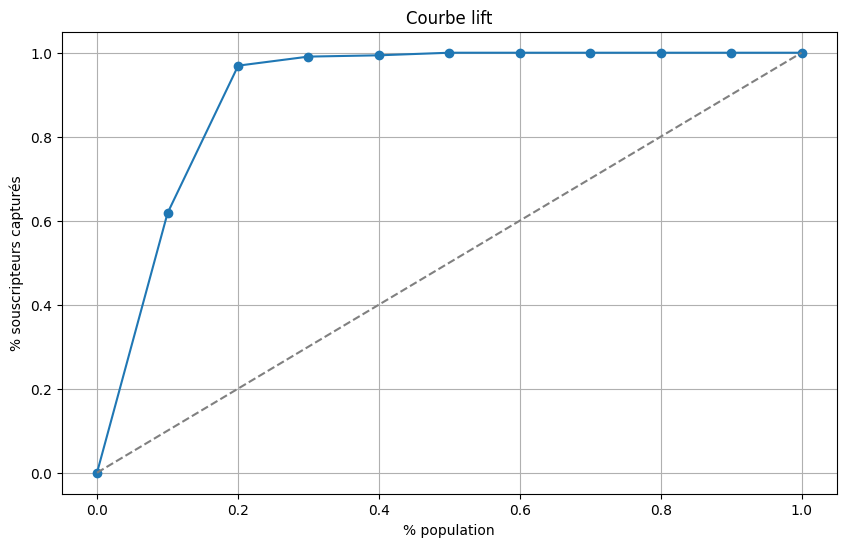

In [146]:
plt.figure(figsize=(10, 6))
x = lift_table["cum_pop"]
y = lift_table["perc_sub_capt"]

plt.plot(x, y, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.title('Courbe lift')
plt.xlabel('% population')
plt.ylabel('% souscripteurs capturés')
plt.grid(True)
plt.show()

In [147]:
def lift(lift_table, pourcentage):
    return round(lift_table[lift_table['segment'] == (20 / 10) - 1]["perc_sub_capt"] / pourcentage * 100, 2)

In [148]:
lift(lift_table=lift_table, pourcentage=20)

2    4.85
Name: perc_sub_capt, dtype: float64

# Analyse des erreurs de mauvais classement

In [173]:
df_recup = pd.DataFrame({'y_pred' : y_pred, 'true': y_test})

In [174]:
X_test

Contacts_Count_12_mon  Total_Relationship_Count  Total_Amt_Chng_Q4_Q1  \
9242                      2                         1                 0.839   
7036                      3                         3                 0.623   
914                       2                         5                 1.632   
9681                      3                         2                 0.827   
9026                      3                         2                 1.021   
...                     ...                       ...                   ...   
5335                      2                         4                 0.666   
4531                      4                         6                 0.678   
5129                      4                         5                 0.679   
6714                      2                         5                 0.911   
8014                      3                         2                 0.729   

      Total_Ct_Chng_Q4_Q1  Total_Revolving_Bal  Total_Trans_Ct  \
9242                0.791                 1990             120   
7036                0.723                    0              81   
914                 0.625                 2431              39   
9681                0.746                 2181             110   
9026                0.698                 2477              73   
...                   ...                  ...             ...   
5335                0.698                  642              90   
4531                1.062                    0              66   
5129                0.771                    0              62   
6714                0.892                 2336              70   
8014                0.735                    0              85   

      Total_Trans_Amt  Months_Inactive_12_mon  Customer_Age  CLIENTNUM  
9242            16202                       1            47  720943308  
7036             4312                       4            51  710879283  
914              1903                       1            55  787800108  
9681            13583                       3            40  789200208  
9026             5294                       3            62  711332883  
...               ...                     ...           ...        ...  
5335             4627                       3            37  718926258  
4531             3999                       2            44  712723608  
5129             3932                       2            43  716739258  
6714             5302                       2            44  715395933  
8014             5025                       2            45  769662033  

[2026 rows x 10 columns]

In [199]:
liste_clients = pd.concat([X_test.reset_index(drop=True), df_recup.reset_index(drop=True)], axis=1).sort_values(by='y_pred', ascending=False)

In [225]:
bien_classés = liste_clients[(liste_clients["y_pred"] == True) & (liste_clients["true"] == 1)] 

In [200]:
l1 = liste_clients[(liste_clients["y_pred"] == False) & (liste_clients["true"] == 1)] 

In [201]:
l2 = liste_clients[(liste_clients["y_pred"] == True) & (liste_clients["true"] == 0)] 

In [239]:
testset_attr = testset[testset["Attrition_Flag"] == "Attrited Customer"]

In [221]:
columns = ['Contacts_Count_12_mon', 'Total_Relationship_Count',
       'Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1', 'Total_Revolving_Bal',
       'Total_Trans_Ct', 'Total_Trans_Amt', 'Months_Inactive_12_mon',
       'Customer_Age']

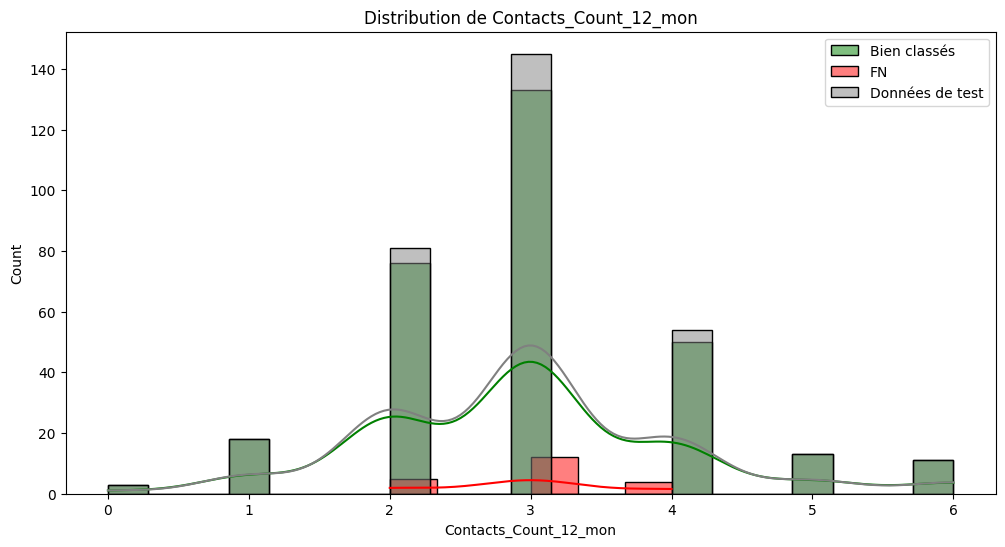

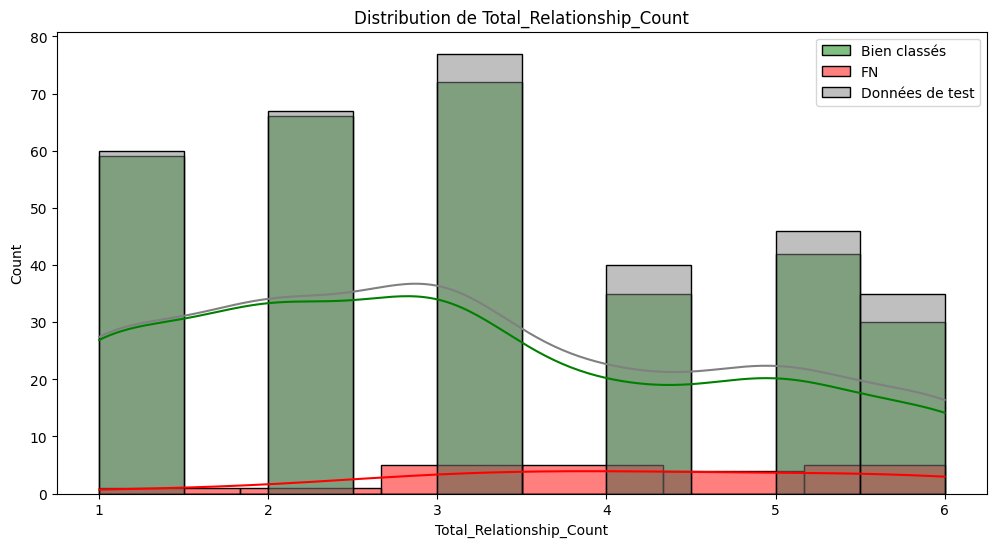

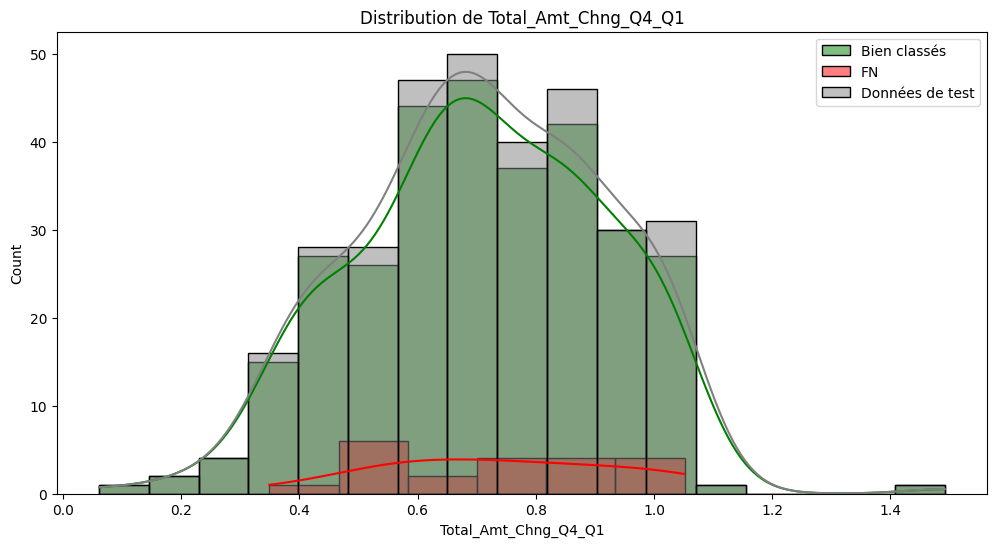

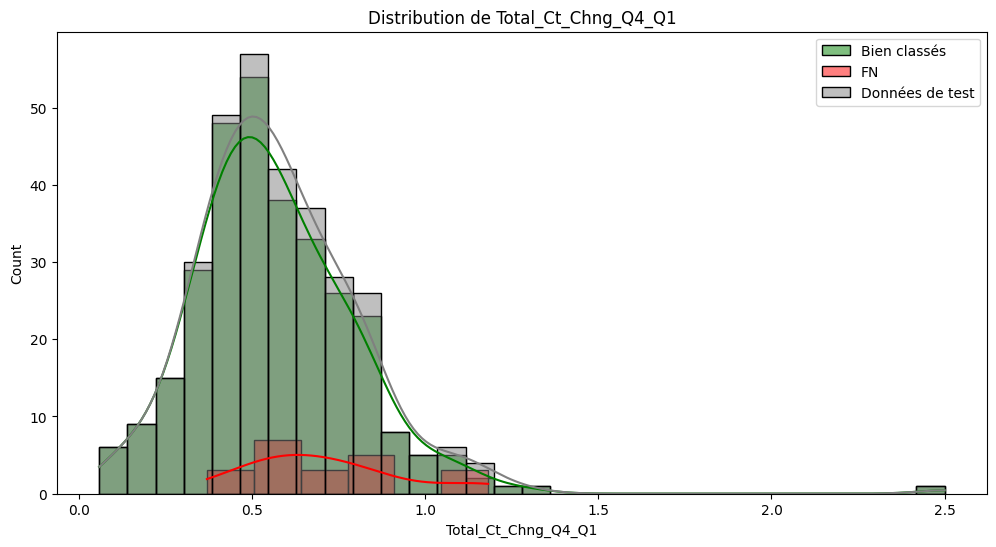

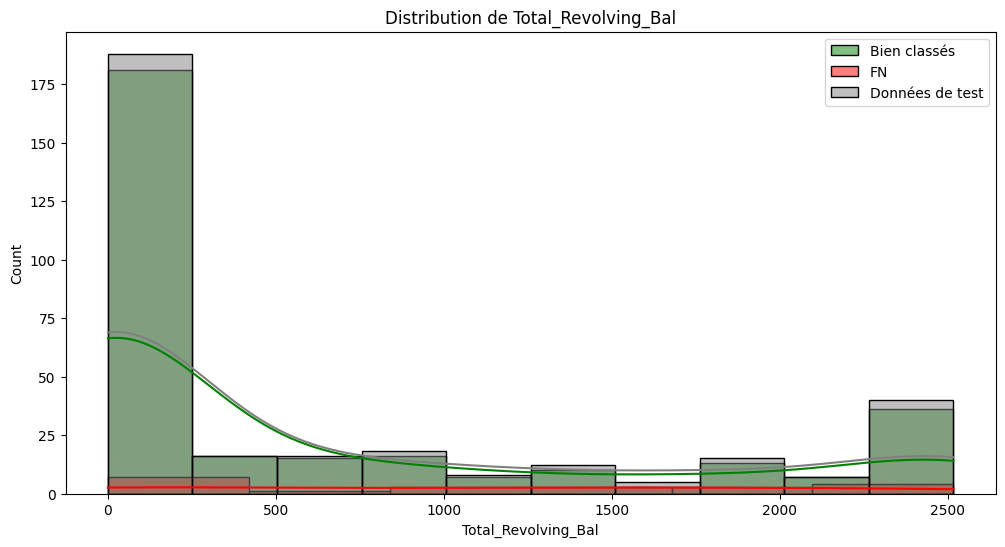

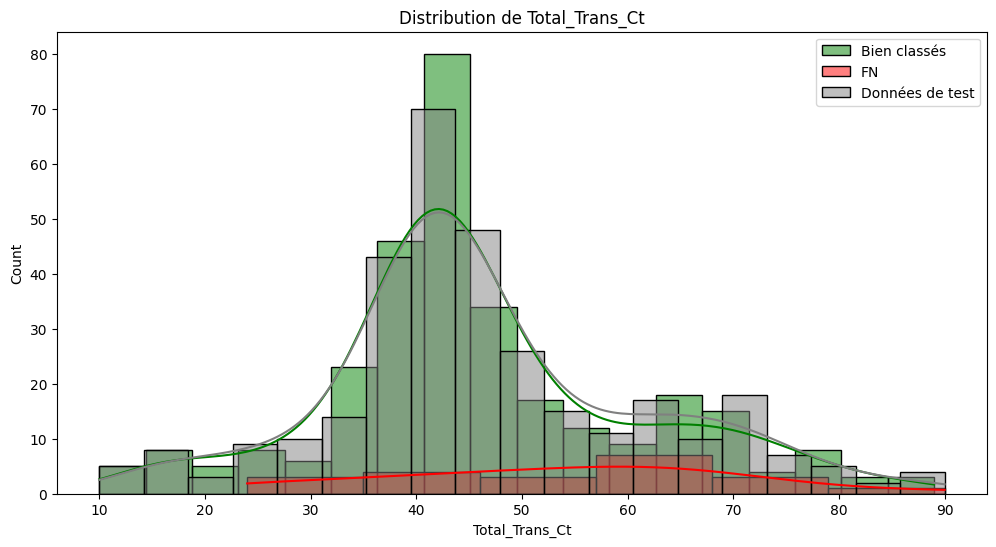

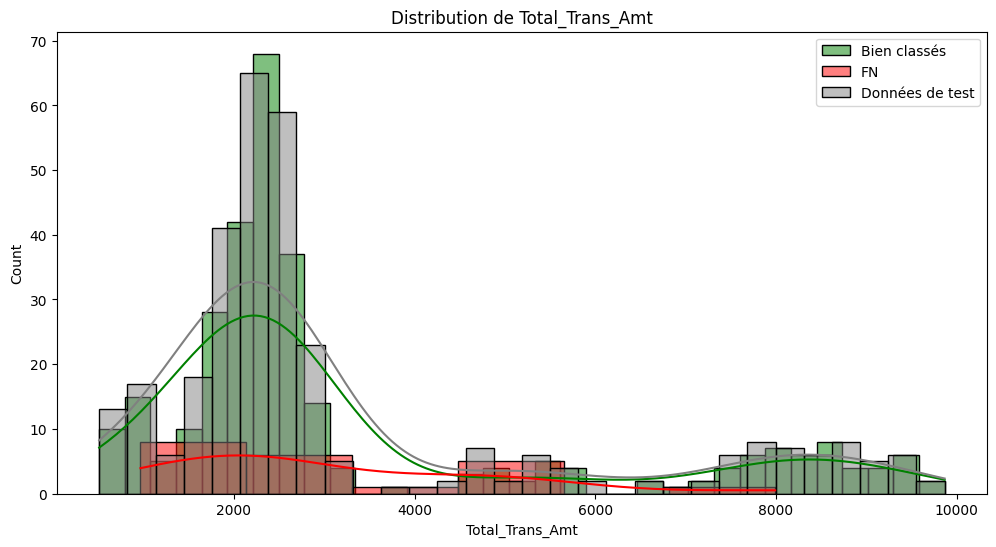

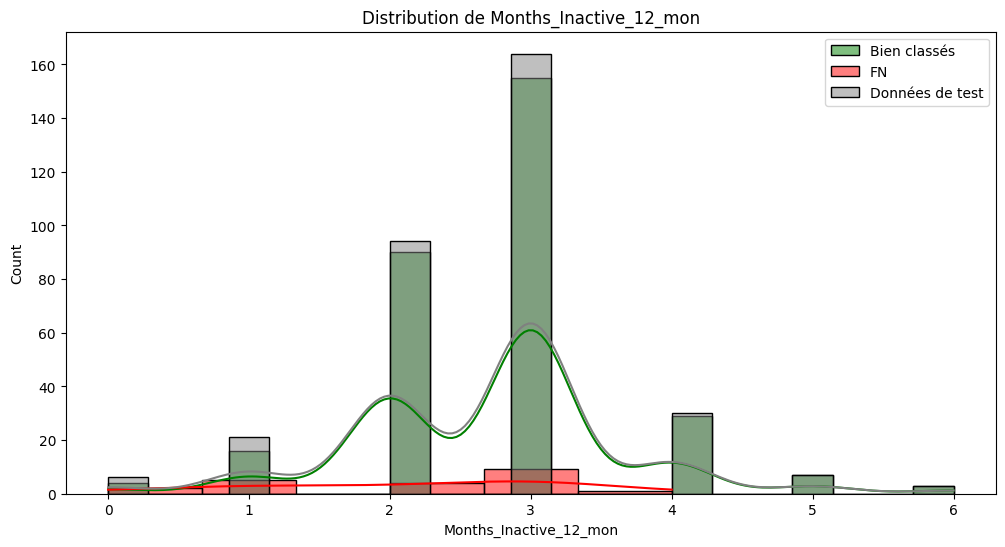

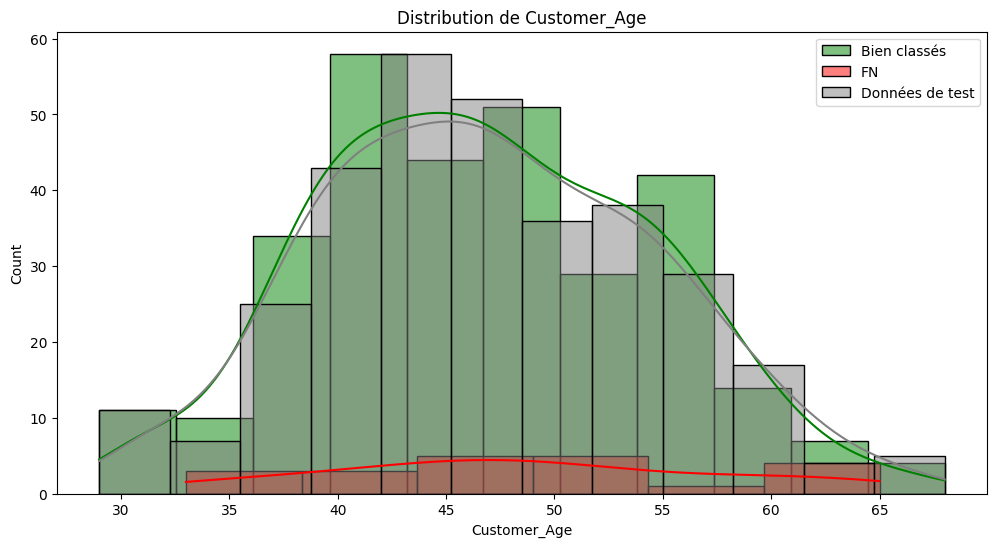

In [242]:
for col in columns:
    plt.figure(figsize=(12, 6))
    
    # Histogramme des clients mal classés
    sns.histplot(bien_classés[col], color='green', label='Bien classés',  kde=True)
    
    # Histogramme des clients bien classés
    sns.histplot(l1[col], color='red', label='FN', kde=True)

    # Histogramme des clients bien classés
    sns.histplot(testset_attr[col], color='grey', label='Données de test',  kde=True)
    
    plt.title(f'Distribution de {col}')
    plt.legend()
    plt.show()

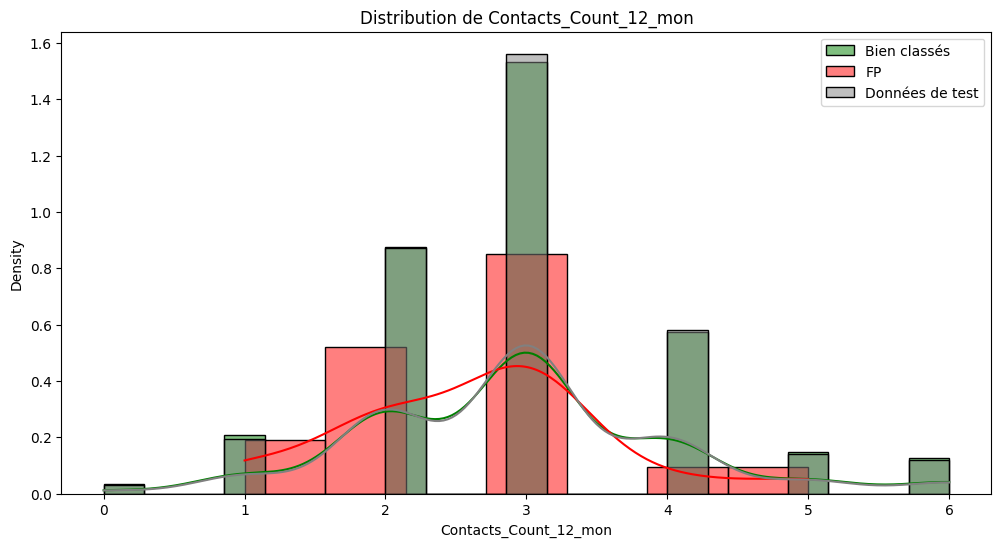

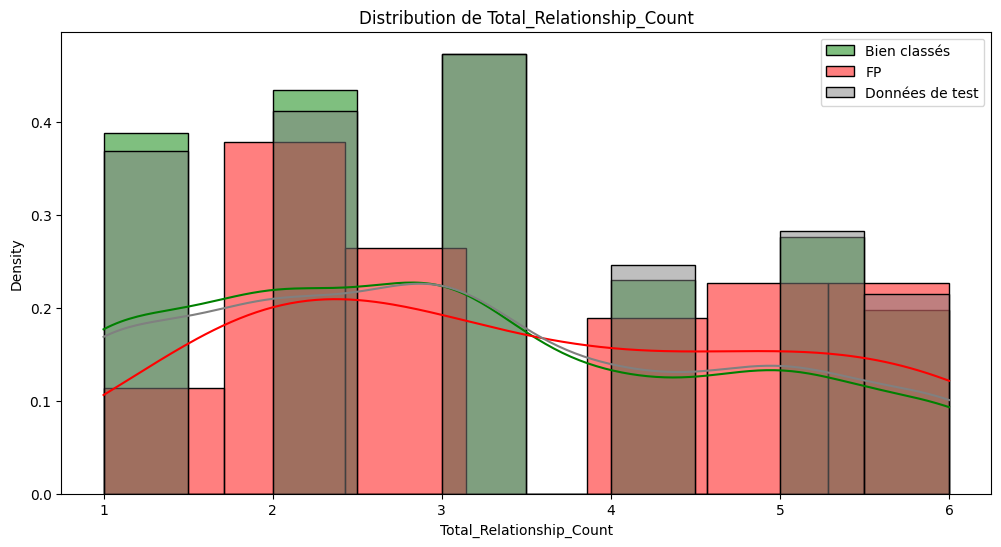

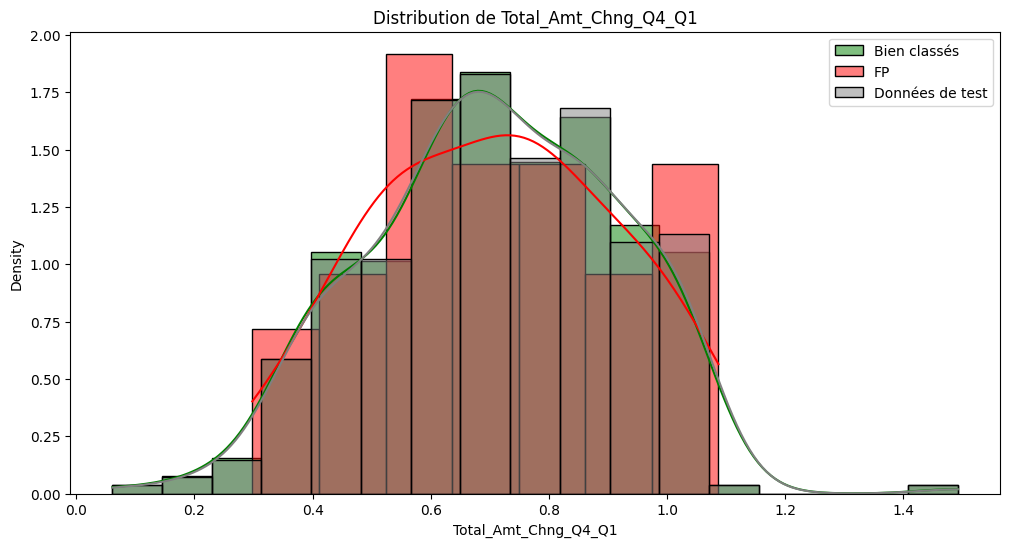

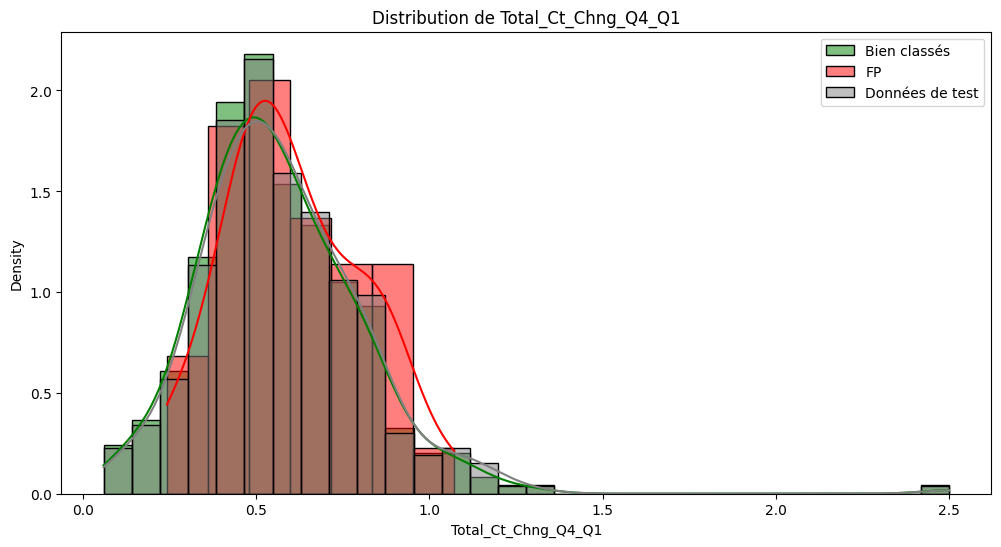

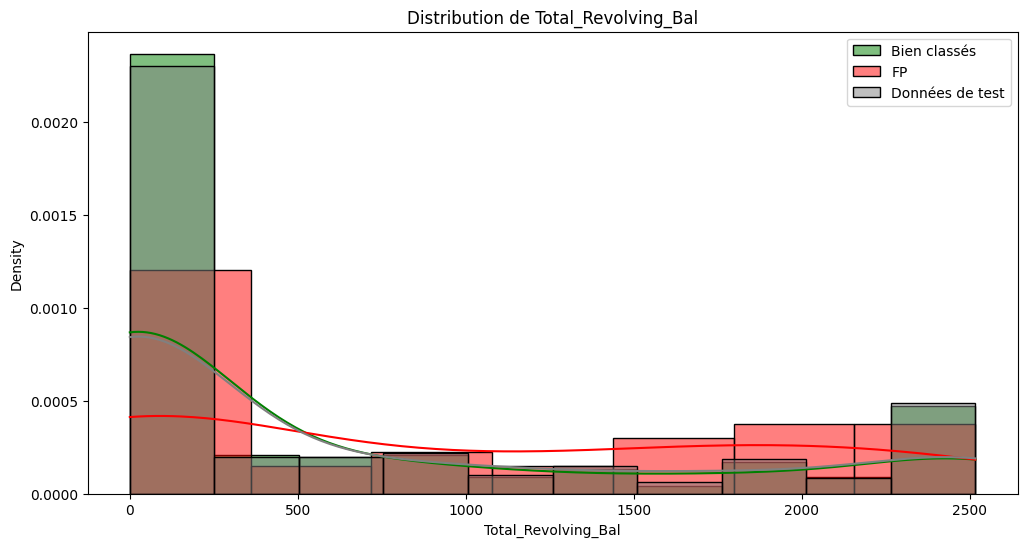

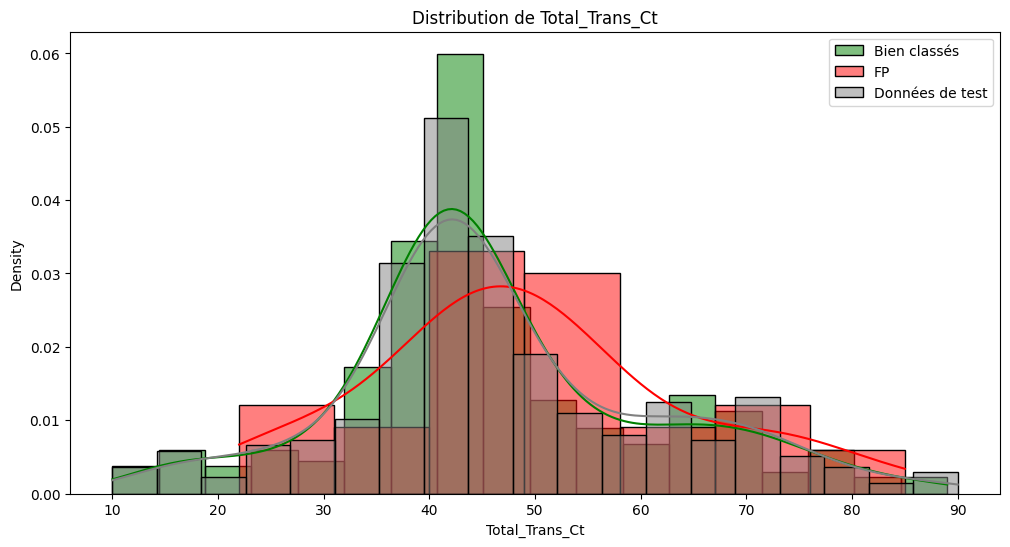

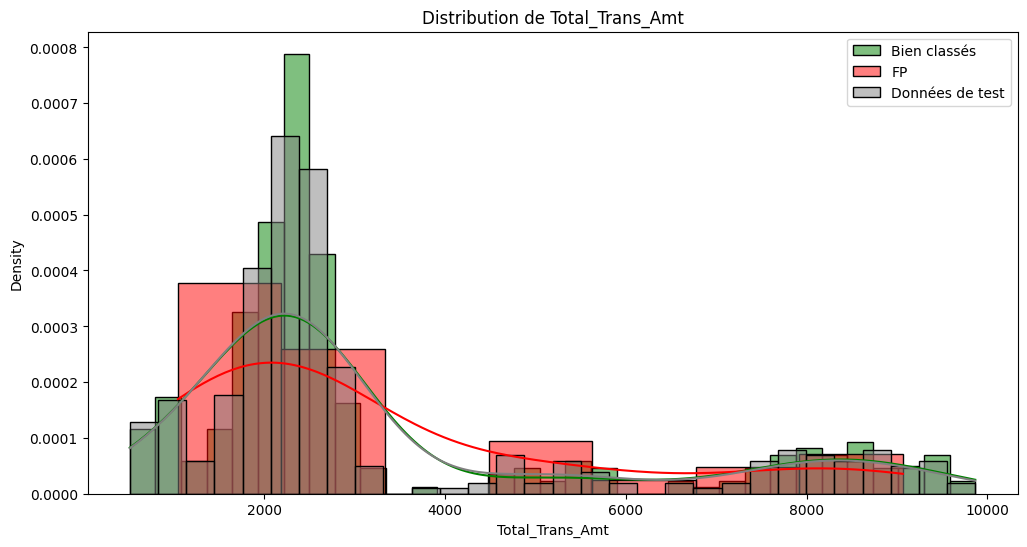

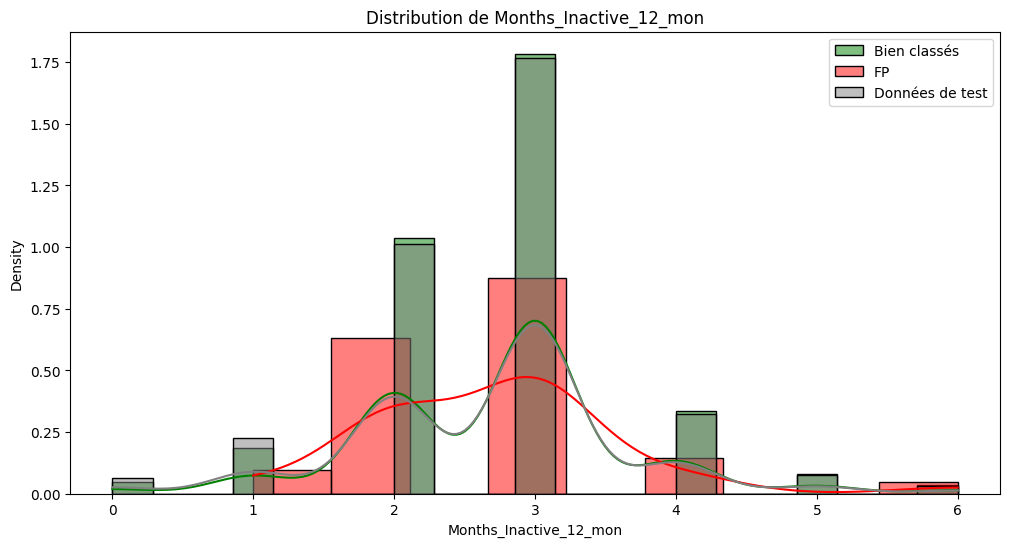

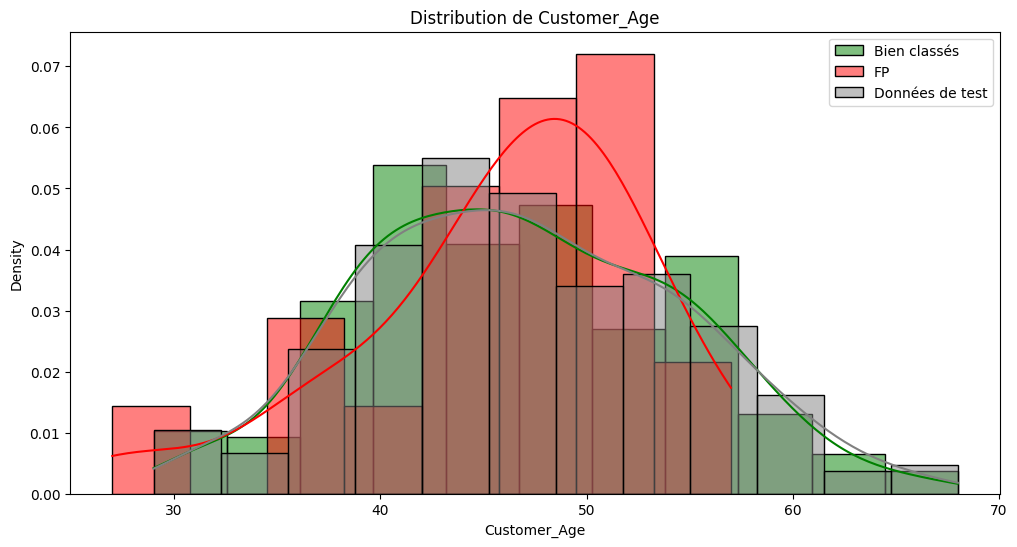

In [241]:
for col in columns:
    plt.figure(figsize=(12, 6))
    
    # Histogramme des clients mal classés
    sns.histplot(bien_classés[col], color='green', label='Bien classés', stat="density", kde=True)
    
    # Histogramme des clients bien classés
    sns.histplot(l2[col], color='red', label='FP', stat="density", kde=True)

    # Histogramme des clients bien classés
    sns.histplot(testset_attr[col], color='grey', label='Données de test', stat="density", kde=True)
    
    plt.title(f'Distribution de {col}')
    plt.legend()
    plt.show()

Malgré la présence d'outliers et quelques erreurs de mauvais classement, le modèle affiche de très bonnes performances globales. Les métriques de performance restent élevées, indiquant des prédictions fiables pour la majorité des clients.

La suppression des outliers pourrait améliorer la robustesse du modèle, mais dans notre cas, avec une base de données de 10 000 clients, cela risque de faire perdre des informations importantes, notamment si ces outliers représentent des segments de clientèle spécifiques. Par conséquent, nous avons choisi de conserver les outliers pour préserver la représentativité complète des données.

En conclusion, notre modèle est performant et la conservation des outliers assure une représentation fidèle et complète de notre clientèle.